In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
from sklearn.metrics import auc
import os
import numpy as np
import pandas as pd 

import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
!ls

calo_association.py
calo_association.pyc
calo_match_dataset.py
ExploreWithCoffea.ipynb
FourGammasGunPt1-100_pythia8_StdMixing_Flat55To75_14TeV_123X_mcRun3_2021_realistic_v11_UL18_pfRechitThres_egmRegNtuples_DeepSC_AlgoA_idealICs.root
FourGammasGunPt1-100_pythia8_StdMixing_Flat55To75_14TeV_123X_mcRun3_2021_realistic_v11_UL18_pfRechitThres_egmRegNtuples_Mustache_idealICs.root
__pycache__
reco_comparison.py
reco_comparison.py~
reco_comparison.pyc
Regression_comparison.ipynb
run_reco_comparison.py
run_reco_comparison.py~
windows_creator_dynamic_global_nooverlap.py
windows_creator_dynamic_global_overlap.py


### Reading the Egamma trees
Reading the files with all the branch and the final branches from the RealIC training

In [2]:
flavour = "Electron"
file_deep = uproot.open("FourElectronsGunPt1-100_pythia8_StdMixing_Flat55To75_14TeV_123X_mcRun3_2021_realistic_v11_UL18_pfRechitThres_egmRegNtuples_DeepSC_AlgoA_idealICs.root")
file_must = uproot.open("FourElectronsGunPt1-100_pythia8_StdMixing_Flat55To75_14TeV_123X_mcRun3_2021_realistic_v11_UL18_pfRechitThres_egmRegNtuples_Mustache_idealICs.root")

In [53]:
flavour = "Gamma"
file_deep = uproot.open("FourGammasGunPt1-100_pythia8_StdMixing_Flat55To75_14TeV_123X_mcRun3_2021_realistic_v11_UL18_pfRechitThres_egmRegNtuples_DeepSC_AlgoA_idealICs.root")
file_must = uproot.open("FourGammasGunPt1-100_pythia8_StdMixing_Flat55To75_14TeV_123X_mcRun3_2021_realistic_v11_UL18_pfRechitThres_egmRegNtuples_Mustache_idealICs.root")

In [3]:
t_m = file_must["egRegTree"]
t_d = file_deep["egRegTree"]
df_m1 = t_m.arrays(["sc", "mc","ssFrac","sim","nrVert"], library="pd")
df_d1 = t_d.arrays(["sc", "mc","ssFrac","sim","nrVert"], library="pd")

Applying some baseline cuts 

In [5]:
mask_d = (df_d1.mc.energy > 0) & (df_d1.ssFrac.sigmaIEtaIEta>0) & (df_d1.ssFrac.sigmaIPhiIPhi>0)
mask_m = (df_m1.mc.energy > 0) & (df_m1.ssFrac.sigmaIEtaIEta>0) & (df_m1.ssFrac.sigmaIPhiIPhi>0)

In [65]:
df_d1 = df_d1[mask_d]
df_m1 = df_m1[mask_m]

/tmp/ipykernel_516/1218526723.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_d1 = df_d1[mask_d]
/tmp/ipykernel_516/1218526723.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_m1 = df_m1[mask_m]


In [4]:
for df in [df_m1, df_d1]:
    df["et_seed"] = df.sc.seedClusEnergy /   np.cosh(df.sc.seedEta)
    df["en_raw"] = df.sc.rawEnergy + df.sc.rawESEnergy
    df["seed_eta"] = df.sc.seedEta
    df["seed_phi"] = df.sc.seedPhi
    df["et_raw"] = df.en_raw /   np.cosh(df.sc.seedEta)
    df["et_gen"] = df.mc.energy / np.cosh(df.sc.seedEta)
    df["et_sim"] = df.sim.energy / np.cosh(df.sc.seedEta)
    df["Eraw_ovEtrue_sim"] =  df.en_raw / df.sim.energy
    df["Eraw_ovEtrue_gen"] = df.en_raw /df.mc.energy

# Basic checks about sim and gen

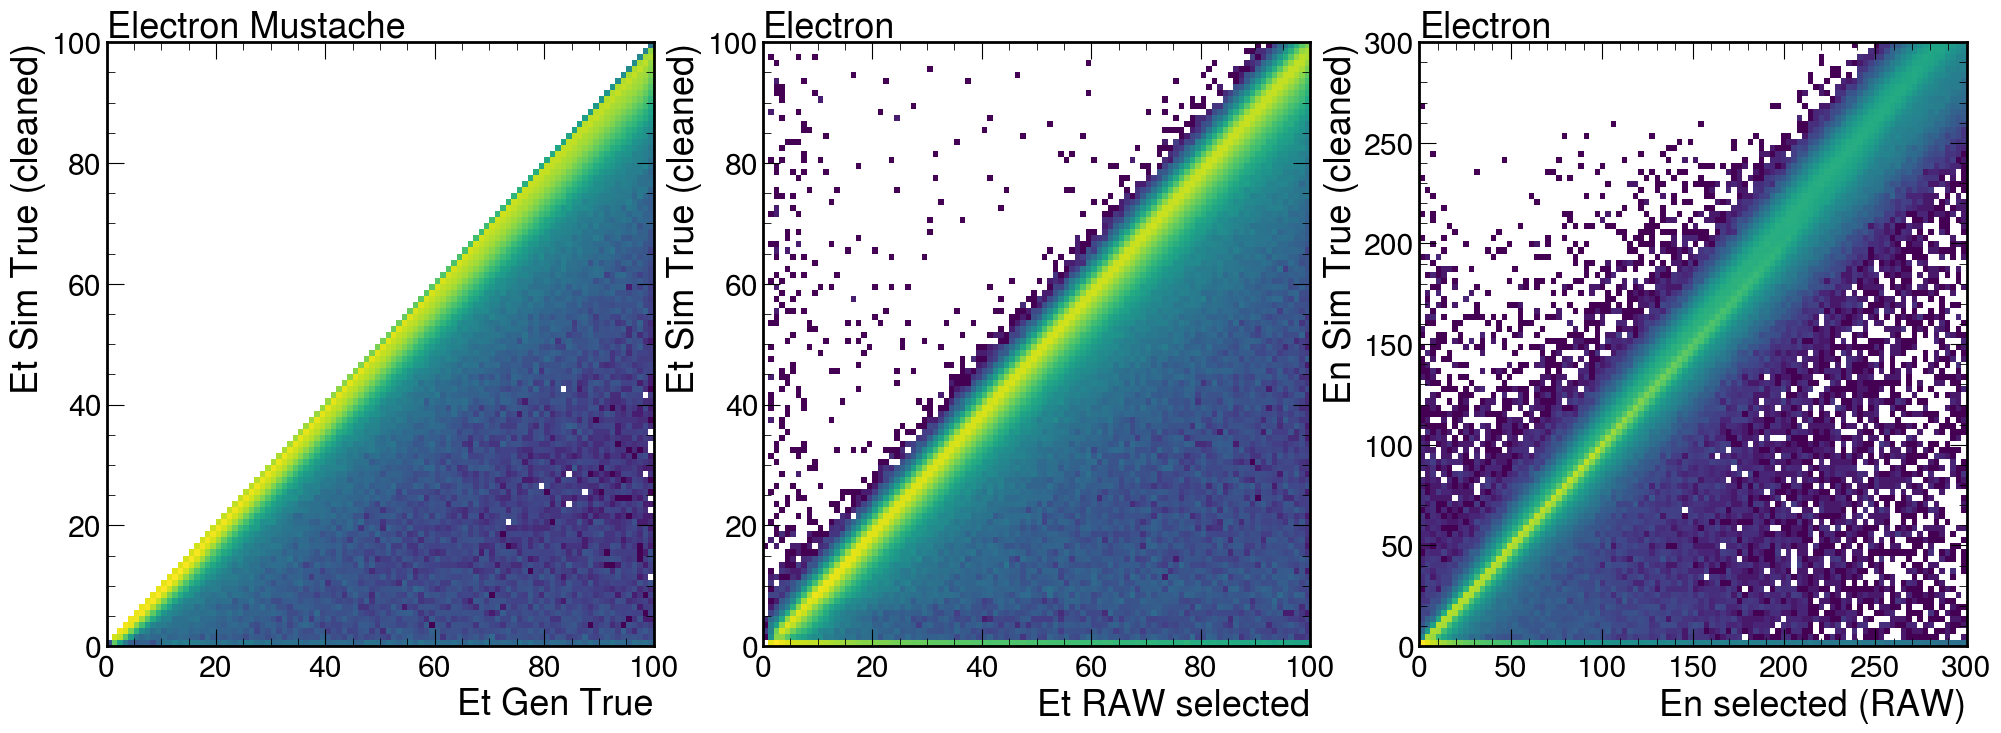

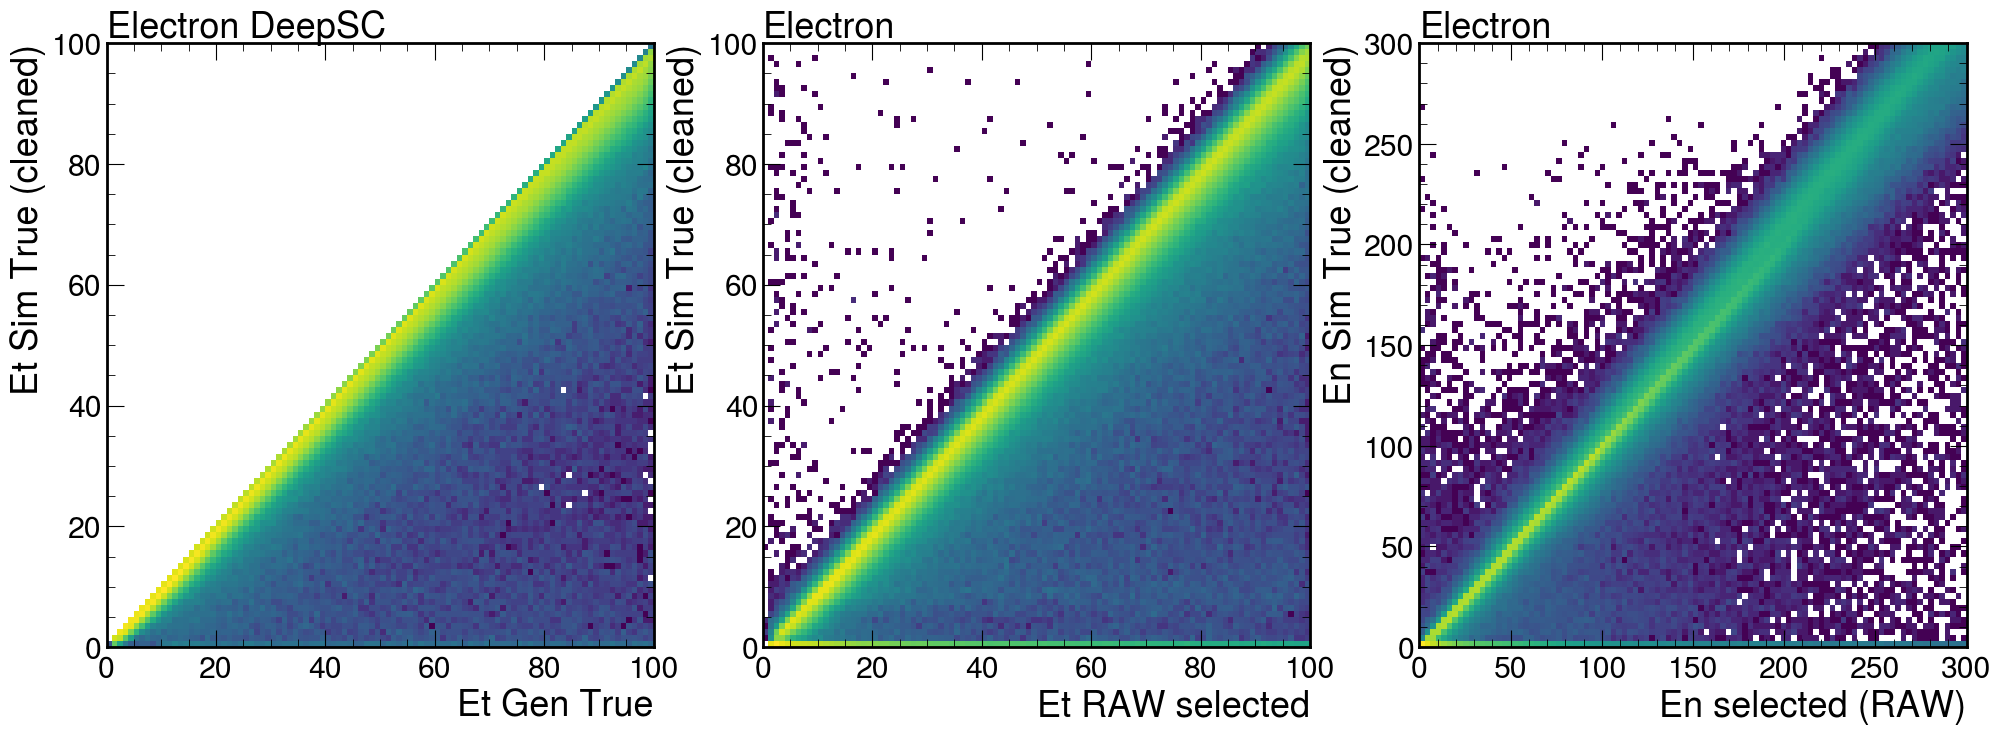

In [8]:
for df,label in zip([df_m1, df_d1],["Mustache", "DeepSC"]):
    fig, (ax,ay,az) = plt.subplots(1,3, figsize=(24,8), dpi=100)
    ax.hist2d(df.et_gen,df.et_sim, bins=(100,100), range=((0,100),(0,100)), norm=colors.LogNorm())
    ax.set_ylabel("Et Sim True (cleaned)")
    ax.set_xlabel("Et Gen True")
    ax.text(0., 1.01, flavour+ " "+label, transform=ax.transAxes)

    ay.hist2d(df.et_gen,df.et_raw, bins=(100,100), range=((0,100),(0,100)), norm=colors.LogNorm())
    ay.set_ylabel("Et Sim True (cleaned)")
    ay.set_xlabel("Et RAW selected")
    ay.text(0., 1.01, flavour, transform=ay.transAxes)

    az.hist2d(df.sim.energy ,df.en_raw, bins=(100,100), range=((0,300),(0,300)), norm=colors.LogNorm())
    az.set_ylabel("En Sim True (cleaned)")
    az.set_xlabel("En selected (RAW)")
    az.text(0., 1.01, flavour, transform=az.transAxes)

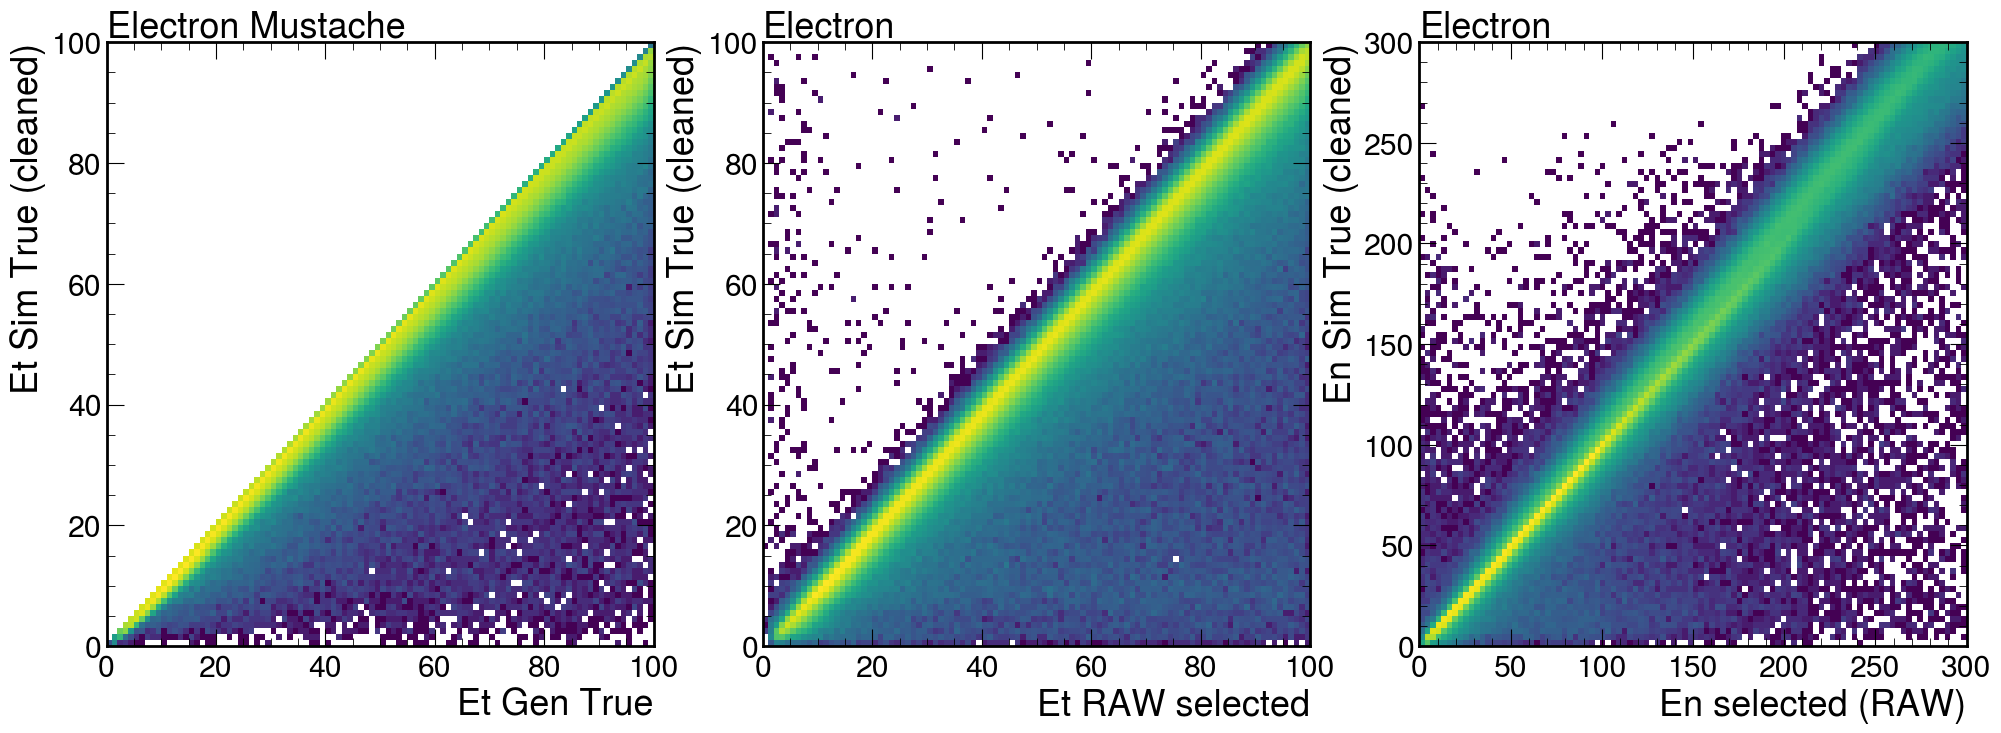

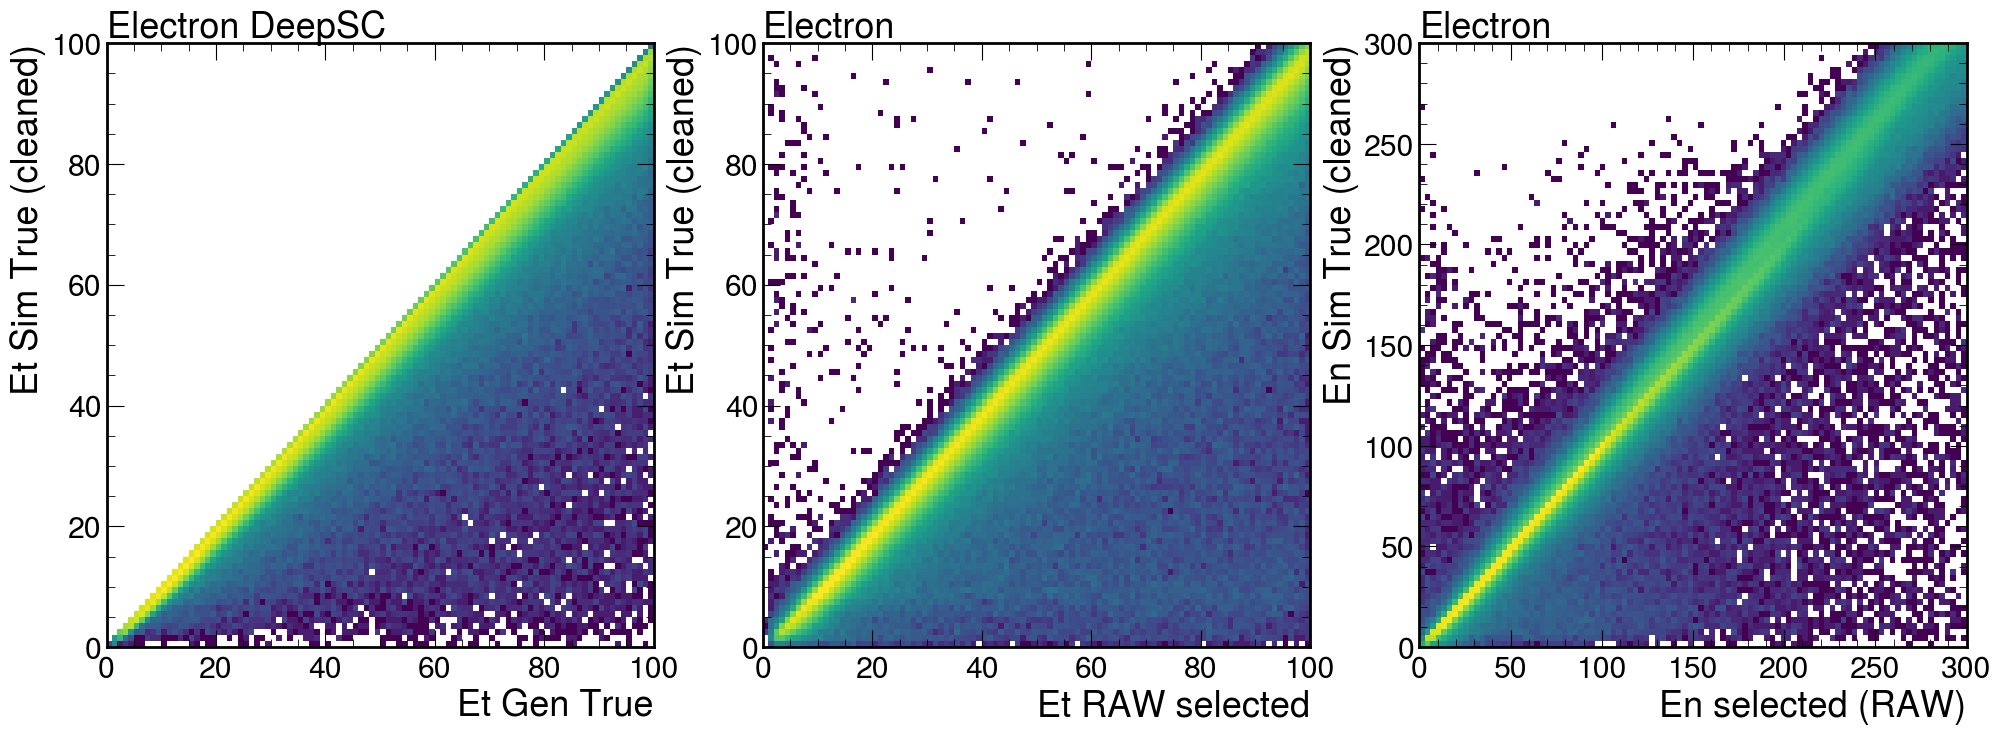

In [9]:
for df,mask, label in zip([df_m1, df_d1],[mask_m, mask_d], ["Mustache", "DeepSC"]):
    fig, (ax,ay,az) = plt.subplots(1,3, figsize=(24,8), dpi=100)
    ax.hist2d(df[mask].et_gen,df[mask].et_sim, bins=(100,100), range=((0,100),(0,100)), norm=colors.LogNorm())
    ax.set_ylabel("Et Sim True (cleaned)")
    ax.set_xlabel("Et Gen True")
    ax.text(0., 1.01, flavour+ " "+label, transform=ax.transAxes)

    ay.hist2d(df[mask].et_gen,df[mask].et_raw, bins=(100,100), range=((0,100),(0,100)), norm=colors.LogNorm())
    ay.set_ylabel("Et Sim True (cleaned)")
    ay.set_xlabel("Et RAW selected")
    ay.text(0., 1.01, flavour, transform=ay.transAxes)

    az.hist2d(df[mask].sim.energy ,df[mask].en_raw, bins=(100,100), range=((0,300),(0,300)), norm=colors.LogNorm())
    az.set_ylabel("En Sim True (cleaned)")
    az.set_xlabel("En selected (RAW)")
    az.text(0., 1.01, flavour, transform=az.transAxes)

(array([13041., 37200., 36039., 36299., 36918., 36980., 37082., 37665.,
        36947., 37094., 37429., 37347., 29655., 38123., 37877., 37258.,
        38379., 37842., 37320., 38442., 38251., 38484., 37714., 37445.,
        37408., 37731., 38377., 38572., 38249., 38517., 38424., 38221.,
        38070., 37794., 37257., 38276., 37634., 29765., 37395., 36542.,
        37172., 37633., 37999., 37374., 37391., 37165., 36136., 36082.,
        35456., 13078.]),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,
         2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ], dtype=float32),
 <BarContainer object of 50 artists>)

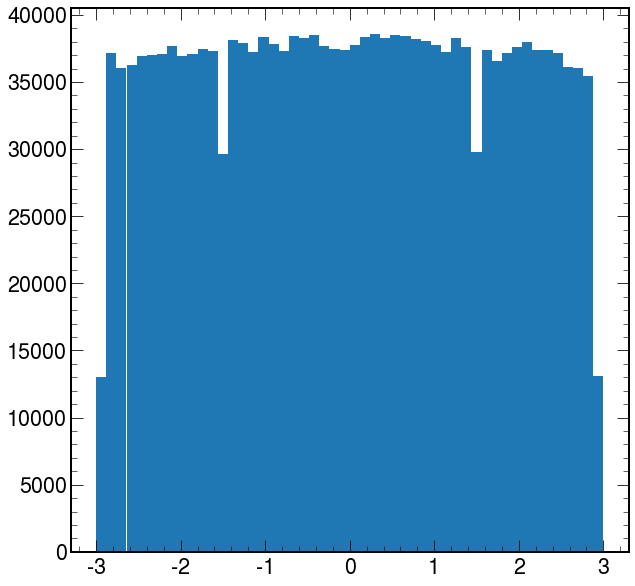

In [15]:
plt.hist(df_d1[mask_d].seed_eta, bins=50, range=(-3,3))

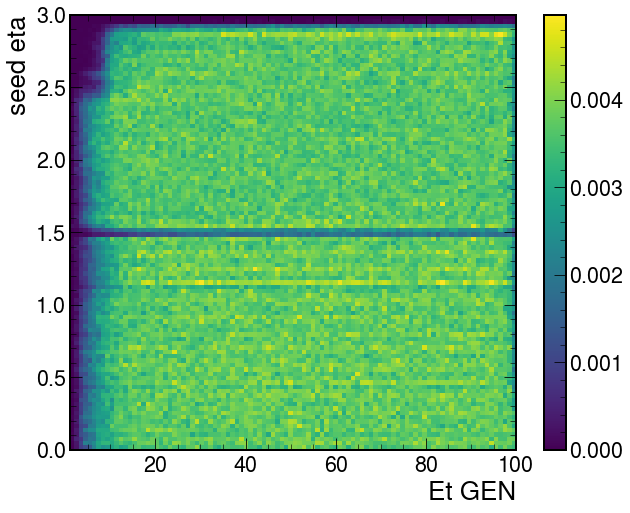

In [16]:
f = plt.figure(figsize=(10,8))
plt.hist2d(df_d1[mask_d].et_gen,df_d1[mask_d].seed_eta.abs(), range=((1,100),(0,3)), bins=(100,100), density=True)
plt.xlabel("Et GEN")
plt.ylabel("seed eta")
plt.colorbar()

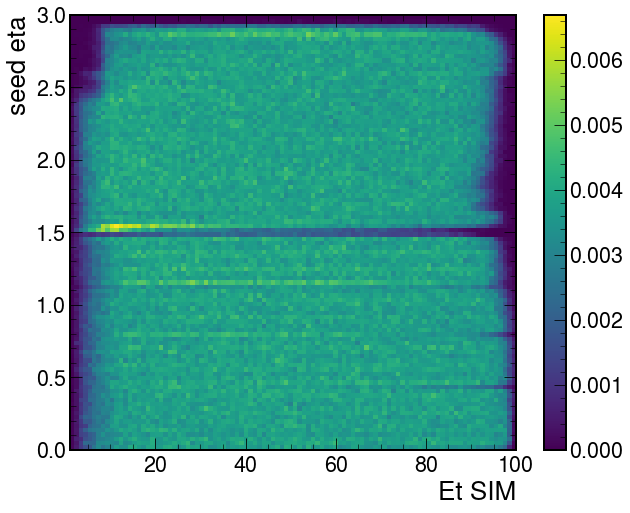

In [18]:
f = plt.figure(figsize=(10,8))
plt.hist2d(df_d1[mask_d].et_sim,df_d1[mask_d].seed_eta.abs(), range=((1,100),(0,3)), bins=(100,100), density=True)
plt.xlabel("Et SIM")
plt.ylabel("seed eta")
plt.colorbar()

# Bin analysis with quantiles

In [211]:
def bin_analysis(col):
    def f(df):
        m = df[col].mean()
        A = (df[col].quantile(0.84) - df[col].quantile(0.16))/2
        B = (df[col].quantile(0.975) - df[col].quantile(0.025))/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "N": df[col].count()
        })
    return f

def bin_analysis_details(col):
    def f(df):
        m = df[col].mean()
        qu = df[col].quantile(0.84)
        qd = df[col].quantile(0.16)
        A = (qu - qd)/2
        quu = df[col].quantile(0.975)
        qdd = df[col].quantile(0.025)
        B = (quu- qdd )/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "w68_u": qu,
            "w68_d": qd,
            "w95_u" : quu,
            "w95_d" : qdd,
            "N": df[col].count()
        })
    return f

def bin_analysis_central_details(col, range=(0,2), nbins=200):
    def f(df):
        data = df[col]
        H = np.histogram(data, bins=nbins, range=range)
        xmax = H[1][np.argmax(H[0])]
        qM = np.sum(data< xmax) / data.count()
        print(qM)
        qu = data.quantile(np.max([qM - 0.34,0]))
        qd = data.quantile(np.min([qM + 0.34,1]))
        A = (qu - qd)/2
        quu = data.quantile(np.max([qM - 0.475,0]))
        qdd = data.quantile(np.min([qM + 0.475,1]))
        B = (quu- qdd )/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "w68_u": qu,
            "w68_d": qd,
            "w95_u" : quu,
            "w95_d" : qdd,
            "N": df[col].count()
        })
    return f


    
def get_sigma_eff(df):
    A = (df.quantile(0.84) - df.quantile(0.16)) /2
    B = (df.quantile(0.975) - df.quantile(0.025)) /2
    return A,B

    
def get_quantiles(df):
    return df.quantile(0.025), df.quantile(0.16), df.quantile(0.5), df.quantile(0.84), df.quantile(0.975)

def get_central_interval(df, range, nbins):
    H = np.histogram(df, bins=nbins, range=range)
    xmax = H[1][np.argmax(H[0])]
    qM = np.sum(df< xmax) / df.count()
    A = df.quantile(np.max([qM - 0.34,0]))
    B = df.quantile(np.min([qM + 0.34,1]))
    return xmax, A, B, qM
   

def bin_analysis_central(col):
    def f(df):
        m = df[col].mean()
        qM = np.sum(df[col]< m) / df[col].count()
        if (qM> 0.66):
            A = (df[col].quantile(1) - df[col].quantile(qM-0.34))/2
        elif (qM < 0.34):
            A = (df[col].quantile(qM +0.34) - df[col].quantile(0))/2
        else:
            A = (df[col].quantile(qM +0.34) - df[col].quantile(qM-0.34))/2
        return pd.Series({
            "m": m,
            "qM": qM,
            "w68": A,
            "N": df[col].count()
        })
    return f

In [320]:
from numba import jit

@jit(nopython=True)
def get_central_smallest_interval(df, xrange, nbins, Ntrial=10000):
    H = np.histogram(df, bins=nbins, range=xrange)
    xmax = H[1][np.argmax(H[0])]
    deltax = (xrange[1]-xrange[0])/(2*Ntrial)
    
    N = df.size
    xd = xmax-deltax
    xu = xmax+deltax
    for i in range(Ntrial):
        q = np.sum((df>xd) &(df<xu))/ N
        if q>=0.68: 
            break
        xd = xd-deltax
        xu = xu+deltax
    return xmax, xd, xu

def bin_analysis_central_smallest(col, xrange=(0.6, 1.2), nbins=200, Ntrial =10000):
    def f(df):
        data = df[col]
        xmax, qd, qu = get_central_smallest_interval(data.values, xrange=xrange, nbins=nbins, Ntrial =Ntrial )
        return pd.Series({
            "m": xmax,
            "w68": (qu-qd)/2,
            "w68_u": qu,
            "w68_d": qd,
            "N": df[col].count()
        })
    return f

# Plot ERaw/EGen

0.99 0.5525287112864288 1.014144742480298 0.3516675218060544
0.23080801559693465
0.99 0.011486929841339588 1.011511190829176 0.30216805644644
0.5000121304939182
0.46160483220464993


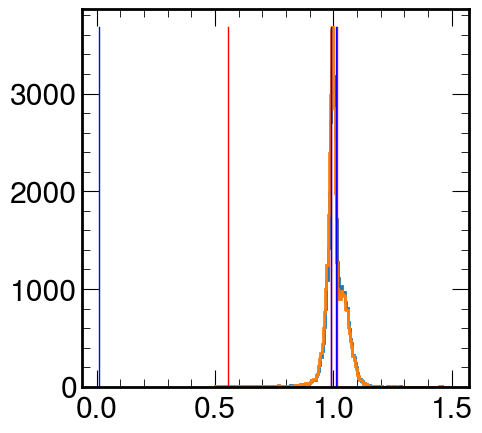

In [341]:
xrange = (0.5,1.5)
bins= 200
var = "Eraw_ovEtrue_sim"

dfx_must = df_m1[(df_m1.et_gen>=80) & (df_m1.et_gen<82) ]
dfx_deep = df_d1[(df_d1.et_gen>=80) & (df_d1.et_gen<82)]
        

fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=100)
ax.hist(dfx_must[var],bins=bins, range=xrange,histtype='step', linewidth=2,
             label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
A= ax.hist(dfx_deep[var],bins=bins, range=xrange,histtype='step',
                linewidth=2, label='DeepSC {:.3f} $\sigma$ 68%'.format(width))
#ax.set_yscale("log")
maxY = np.max(A[0])

m, a,b, qM = get_central_interval(dfx_deep[var], range=(0,2), nbins=200)
print(m,a,b,qM)
print((b-a)/2)

m2, a2,b2, qM2 = get_central_interval(dfx_must[var], range=(0,2), nbins=200)

print(m2,a2,b2,qM2)
print((b2-a2)/2)

print((b-a)/(b2-a2) )
ax.plot([m,m],[0,maxY], color="red", linewidth=1,)
ax.plot([a,a],[0,maxY], color="red", linewidth=1, )
ax.plot([b,b],[0,maxY], color="red", linewidth=1, )

ax.plot([m2,m2],[0,maxY], color="blue", linewidth=1,)
ax.plot([a2,a2],[0,maxY], color="blue", linewidth=1, )
ax.plot([b2,b2],[0,maxY], color="blue", linewidth=1, )


CPU times: user 64.2 ms, sys: 827 µs, total: 65 ms
Wall time: 66.2 ms
0.831 0.7218900000000927 0.9401099999999072
0.10910999999990723
CPU times: user 73.7 ms, sys: 1.66 ms, total: 75.3 ms
Wall time: 75.7 ms
0.876 0.7483200000001086 1.0036799999998915
0.1276799999998915
0.8545582706766913


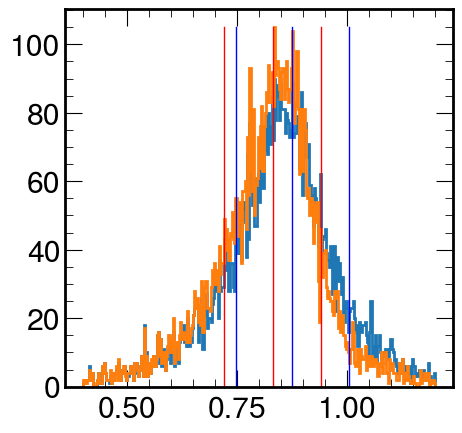

In [348]:
xrange = (0.4,1.2)
bins= 300
var = "Eraw_ovEtrue_sim"
emin = 4
emax =6

dfx_must = df_m1[(df_m1.et_gen>=emin) & (df_m1.et_gen<emax) &(df_m1.seed_eta.abs()<1.45)]
dfx_deep = df_d1[(df_d1.et_gen>=emin) & (df_d1.et_gen<emax)&(df_d1.seed_eta.abs()<1.45)]
        

fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=100)
ax.hist(dfx_must[var],bins=bins, range=xrange,histtype='step', linewidth=2,
             label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
A= ax.hist(dfx_deep[var],bins=bins, range=xrange,histtype='step',
                linewidth=2, label='DeepSC {:.3f} $\sigma$ 68%'.format(width))
#ax.set_yscale("log")
maxY = np.max(A[0])

%time m, a,b = get_central_smallest_interval(dfx_deep[var].values, xrange=(0.6, 1.2), nbins=200, Ntrial =10000)
print(m,a,b)
print((b-a)/2)

%time m2, a2,b2 = get_central_smallest_interval(dfx_must[var].values,xrange=(0.6, 1.2), nbins=200,Ntrial =10000)

print(m2,a2,b2)
print((b2-a2)/2)

print((b-a)/(b2-a2) )
ax.plot([m,m],[0,maxY], color="red", linewidth=1,)
ax.plot([a,a],[0,maxY], color="red", linewidth=1, )
ax.plot([b,b],[0,maxY], color="red", linewidth=1, )

ax.plot([m2,m2],[0,maxY], color="blue", linewidth=1,)
ax.plot([a2,a2],[0,maxY], color="blue", linewidth=1, )
ax.plot([b2,b2],[0,maxY], color="blue", linewidth=1, )

#ax.set_yscale("log")


0.3516675218060544


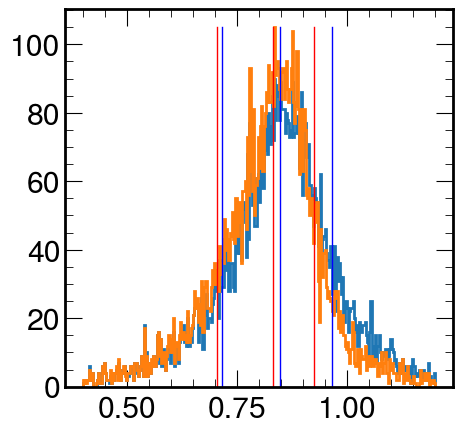

In [347]:
xrange = (0.4,1.2)
bins= 300
var = "Eraw_ovEtrue_sim"
emin = 4
emax = 6

dfx_must = df_m1[(df_m1.et_gen>=emin) & (df_m1.et_gen<emax) &(df_m1.seed_eta.abs()<1.45)]
dfx_deep = df_d1[(df_d1.et_gen>=emin) & (df_d1.et_gen<emax)&(df_d1.seed_eta.abs()<1.45)]
        


fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=100)
ax.hist(dfx_must[var],bins=bins, range=xrange,histtype='step', linewidth=2,
             label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
A= ax.hist(dfx_deep[var],bins=bins, range=xrange,histtype='step',
                linewidth=2, label='DeepSC {:.3f} $\sigma$ 68%'.format(width))
#ax.set_yscale("log")
maxY = np.max(A[0])

q1,q2,M, q3,q4 = get_quantiles(dfx_deep[var])
Q1,Q2,M2, Q3,Q4 = get_quantiles(dfx_must[var])

print(qM)
ax.plot([M,M],[0,maxY], color="red", linewidth=1,)
ax.plot([q2,q2],[0,maxY], color="red", linewidth=1, )
ax.plot([q3,q3],[0,maxY], color="red", linewidth=1, )

ax.plot([M2,M2],[0,maxY], color="blue", linewidth=1,)
ax.plot([Q2,Q2],[0,maxY], color="blue", linewidth=1, )
ax.plot([Q3,Q3],[0,maxY], color="blue", linewidth=1, )


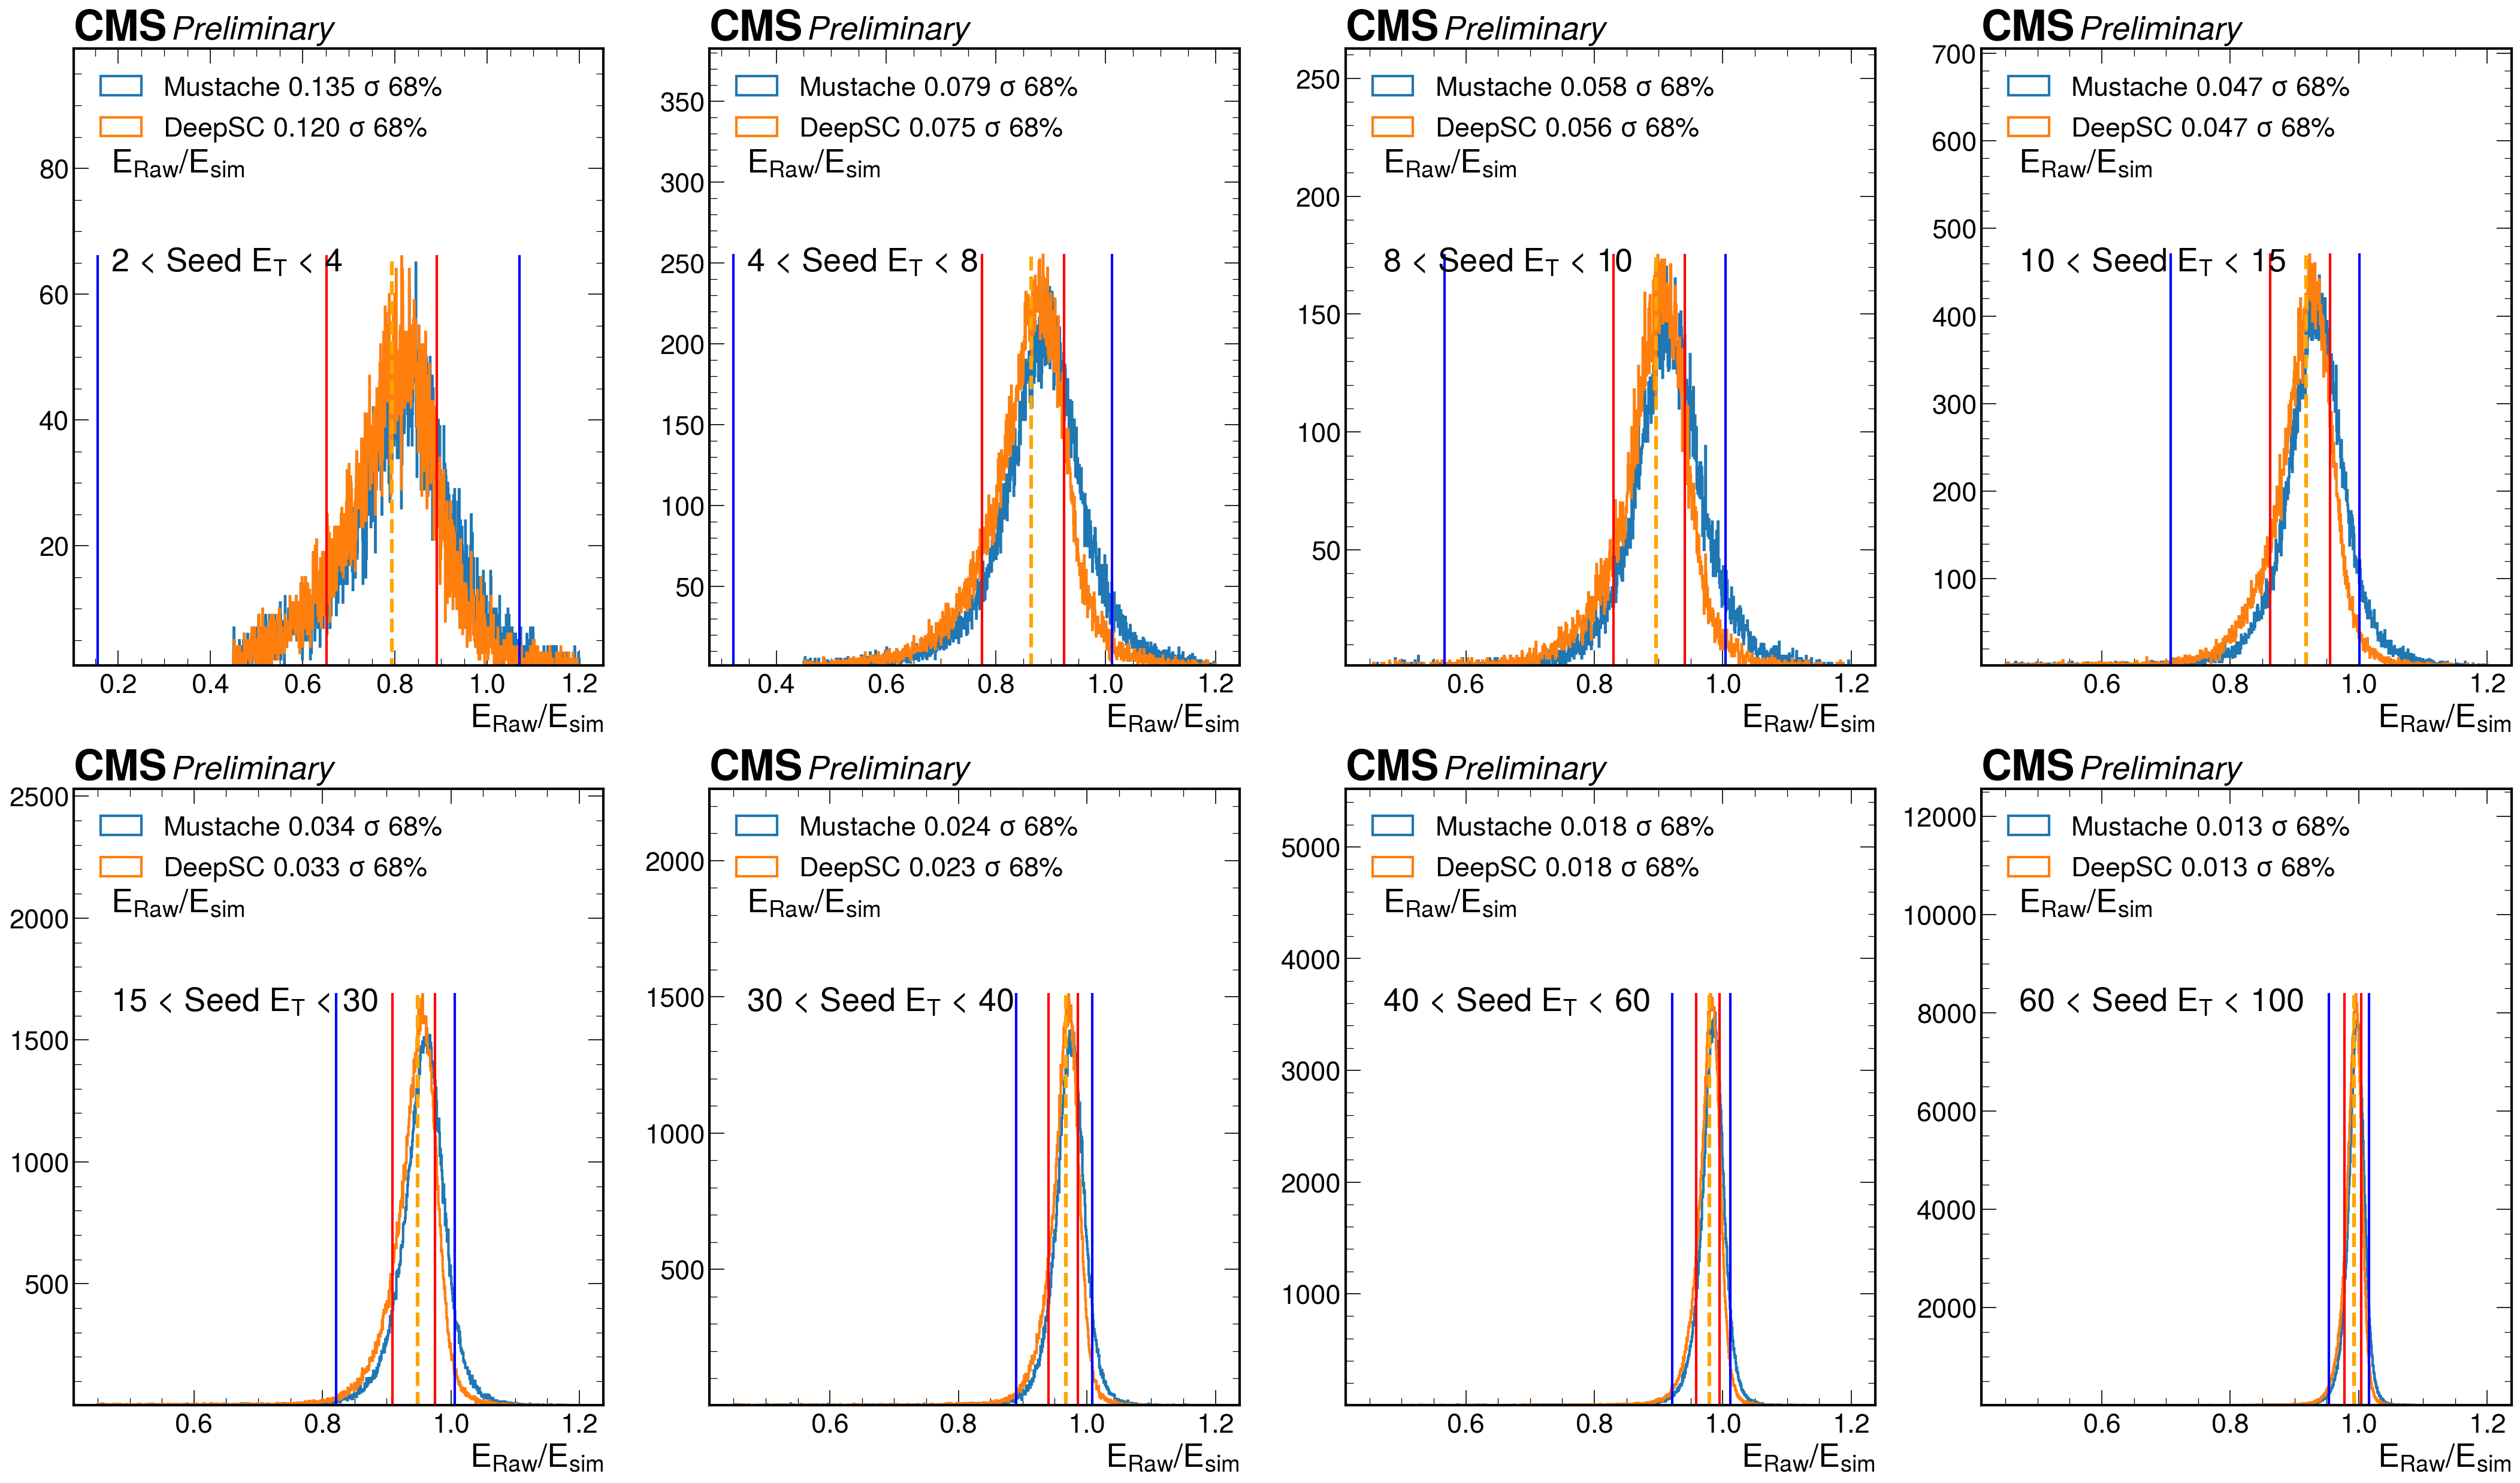

In [53]:
fig, ax = plt.subplots(2,4, figsize=(35,20),dpi=150)

xrange = (0.45, 1.2)
bins= 1000
flavour = "$E_{Raw}/E_{sim}$"
var = "Eraw_ovEtrue_sim"

r = [2, 4, 8, 10, 15, 30 ,40, 60,100]
s = [[], []]
for i in range(len(r)-1):
    line = i //4 
    s[line].append((r[i],r[i+1]))

for j,ss in enumerate(s): 
    for i, (e1,e2) in enumerate(ss): 
        dfx_must = df_m1[(abs(df_m1.et_seed)>=e1) & (abs(df_m1.et_seed)<e2) & (abs(df_m1.seed_eta)<1.47) ]
        dfx_deep = df_d1[(abs(df_d1.et_seed)>=e1) & (abs(df_d1.et_seed)<e2)& (abs(df_d1.seed_eta)<1.47)]
        
        width, width_2 = get_sigma_eff(dfx_deep[var])
        width_must, width_2_must = get_sigma_eff(dfx_must[var])
        
        a,b,c,d,e = get_quantiles(dfx_deep[var])

        ax[j,i].hist(dfx_must[var],bins=bins, range=xrange,histtype='step', linewidth=2,
                     label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
        A= ax[j,i].hist(dfx_deep[var],bins=bins, range=xrange,histtype='step',
                        linewidth=2, label='DeepSC {:.3f} $\sigma$ 68%'.format(width))
        maxY = np.max(A[0])
        
        ax[j,i].plot([a,a],[0,maxY], color="blue", linewidth=2)
        ax[j,i].plot([e,e],[0,maxY], color="blue", linewidth=2)
        ax[j,i].plot([b,b],[0,maxY], color="red", linewidth=2)
        ax[j,i].plot([d,d],[0,maxY], color="red", linewidth=2)
        ax[j,i].plot([c,c],[0,maxY], color="orange", linewidth=3, linestyle='dashed')
    
        ax[j,i].legend(loc="upper left")
        ax[j,i].set_ylim(1, 1.5 * maxY)
        ax[j,i].set_xlabel(flavour)
        ax[j,i].text(0.07,0.64,  str(e1) + ' < Seed $E_T$ < ' + str(e2), transform = ax[j,i].transAxes)  
        ax[j,i].text(0.07, 0.8, flavour, transform=ax[j,i].transAxes)

        hep.cms.text("Preliminary ",loc=0, ax=ax[j,i])


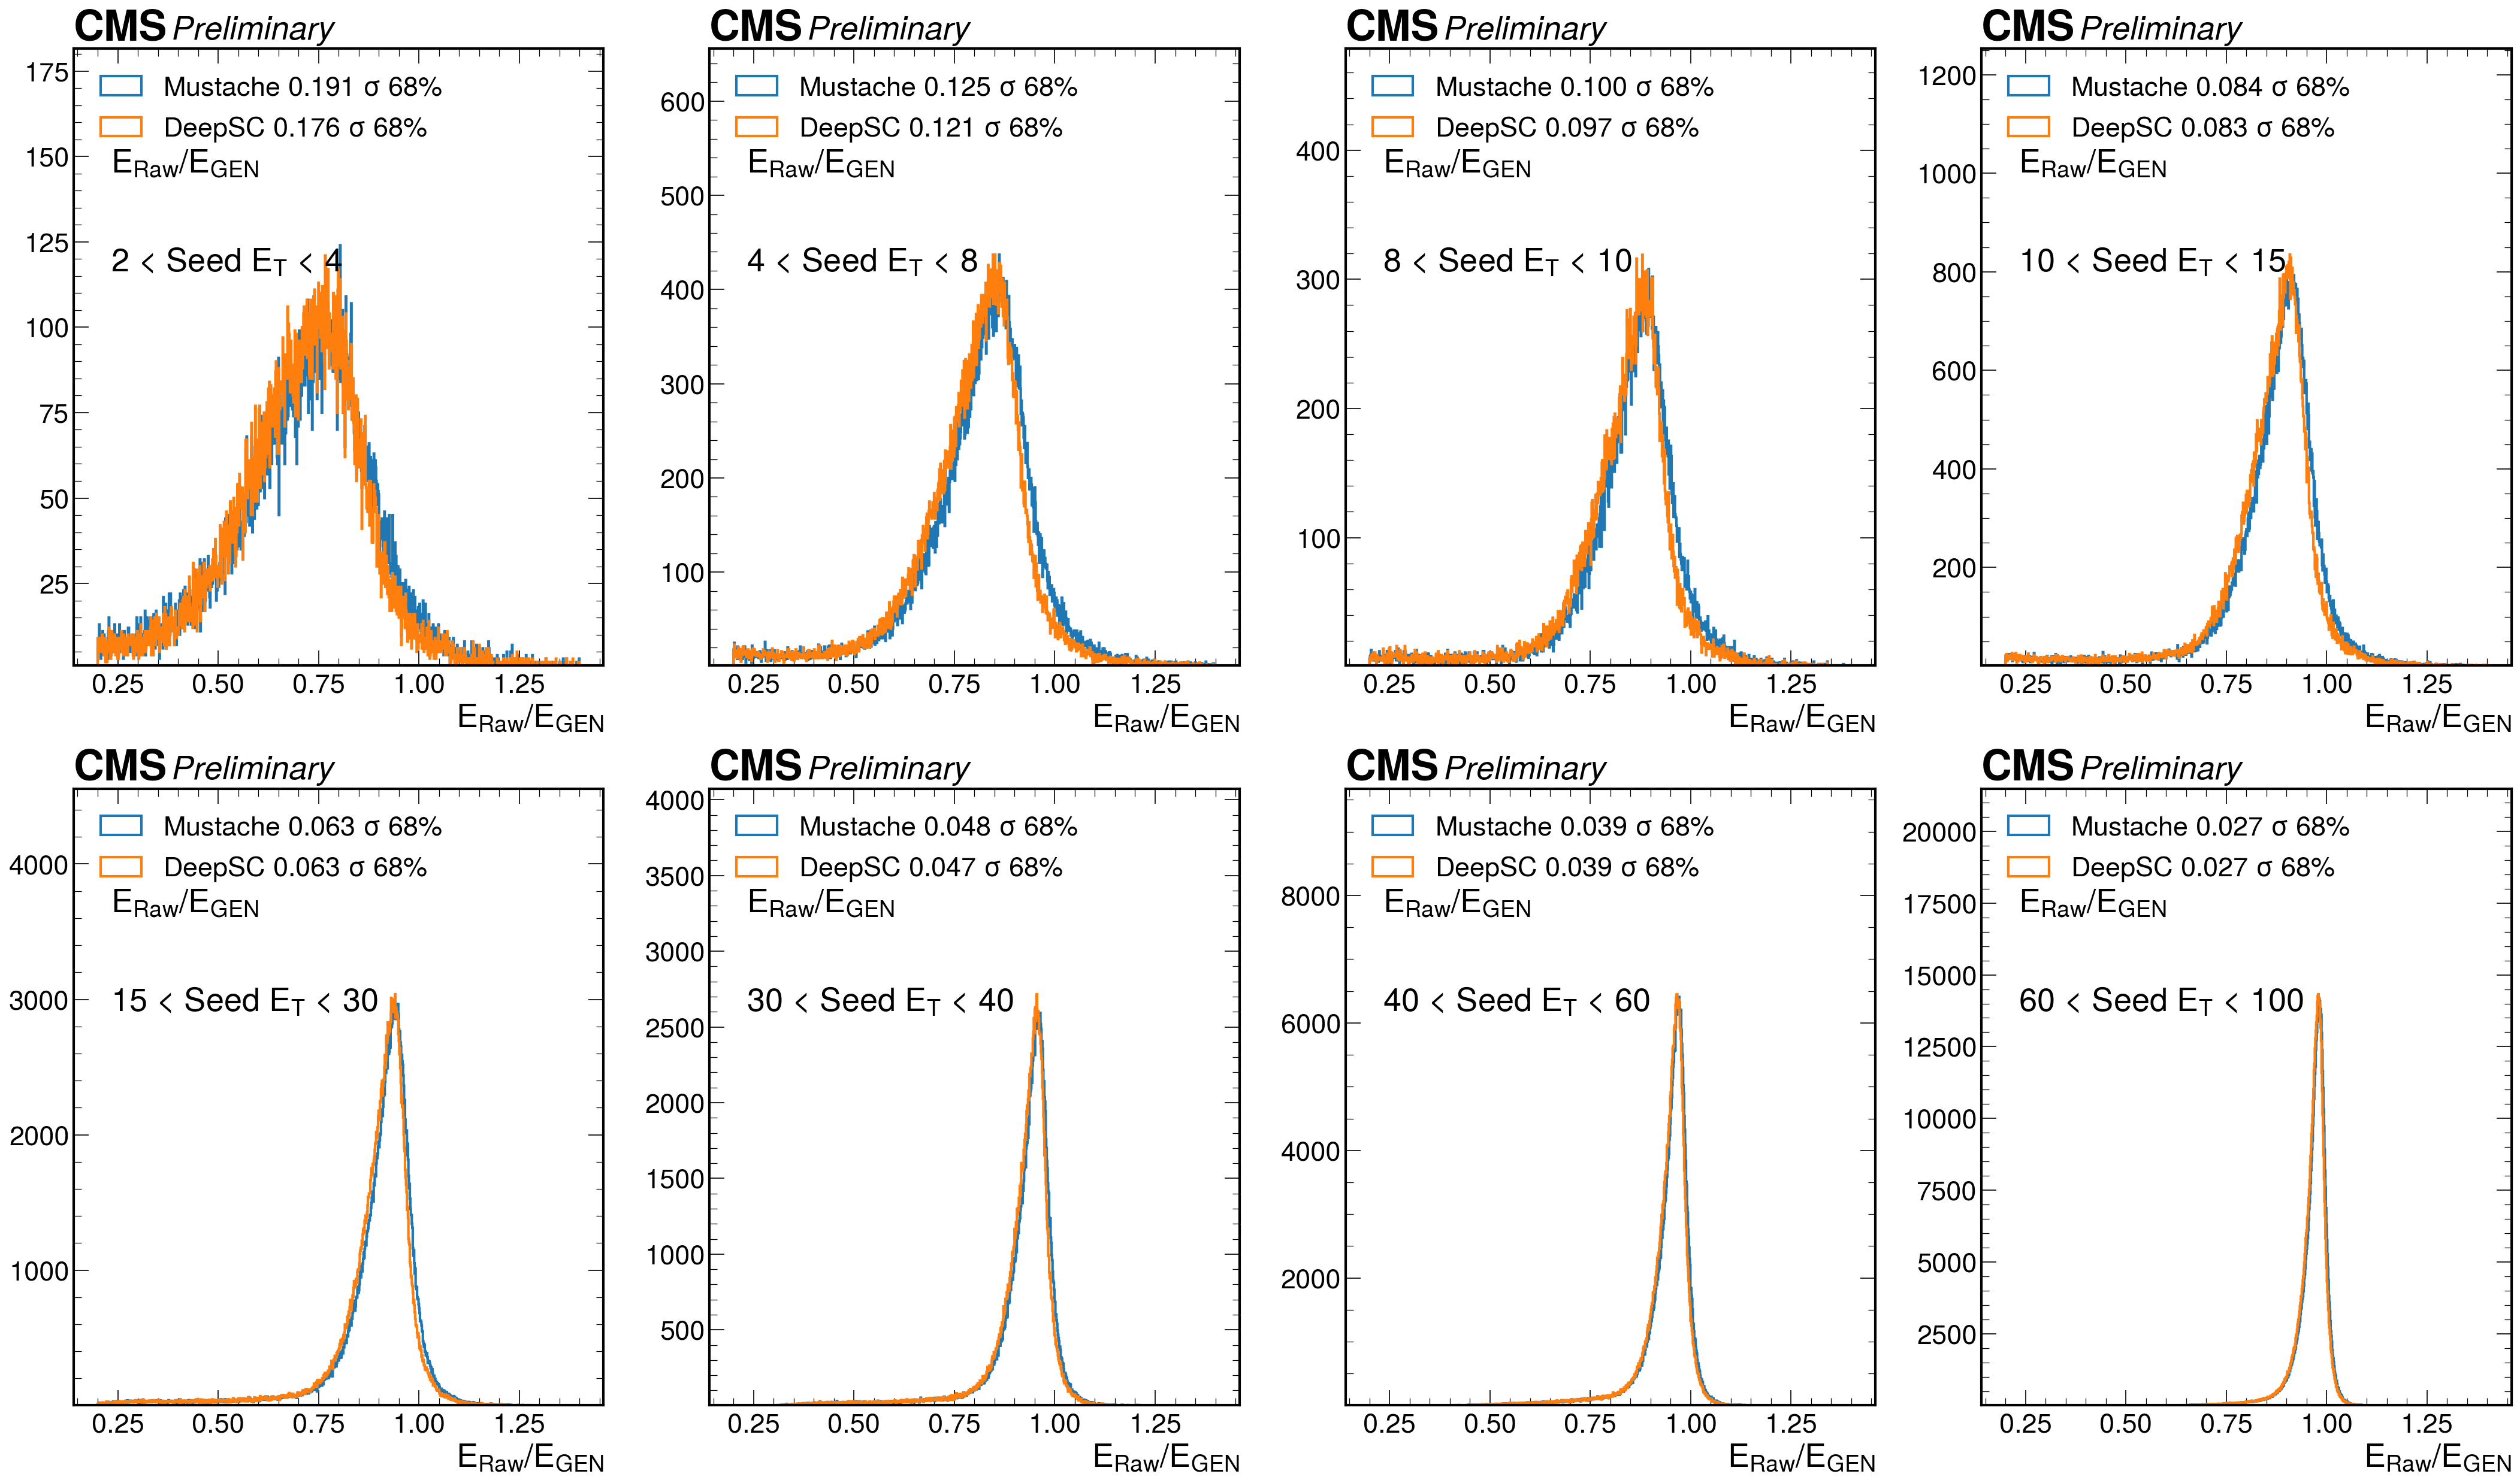

In [8]:
fig, ax = plt.subplots(2,4, figsize=(35,20),dpi=150)

xrange = (0.2, 1.4)
bins= 1000
flavour = "$E_{Raw}/E_{GEN}$"
var = "Eraw_ovEtrue_gen"

r = [2, 4, 8, 10, 15, 30 ,40, 60,100]
s = [[], []]
for i in range(len(r)-1):
    line = i //4 
    s[line].append((r[i],r[i+1]))

for j,ss in enumerate(s): 
    for i, (e1,e2) in enumerate(ss): 
        dfx_must = df_m1[(abs(df_m1.et_seed)>=e1) & (abs(df_m1.et_seed)<e2)]
        dfx_deep = df_d1[(abs(df_d1.et_seed)>=e1) & (abs(df_d1.et_seed)<e2)]

        width, width_2 = get_sigma_eff(dfx_deep[var])
        width_must, width_2_must = get_sigma_eff(dfx_must[var])

        ax[j,i].hist(dfx_must[var],bins=bins, range=xrange,histtype='step', linewidth=2, label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
        A= ax[j,i].hist(dfx_deep[var],bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC {:.3f} $\sigma$ 68%'.format(width))
        maxY = np.max(A[0])
        ax[j,i].legend(loc="upper left")
        ax[j,i].set_ylim(1, 1.5 * maxY)
        ax[j,i].set_xlabel(flavour)
        ax[j,i].text(0.07,0.64,  str(e1) + ' < Seed $E_T$ < ' + str(e2), transform = ax[j,i].transAxes)  
        ax[j,i].text(0.07, 0.8, flavour, transform=ax[j,i].transAxes)

        hep.cms.text("Preliminary ",loc=0, ax=ax[j,i])


## Checked on resolution Raw/Sim

(array([1.0000e+01, 2.0200e+02, 1.4280e+03, 4.0420e+03, 6.3590e+03,
        8.3430e+03, 1.0344e+04, 1.1971e+04, 1.3456e+04, 1.5176e+04,
        1.6556e+04, 1.7661e+04, 1.8314e+04, 1.8316e+04, 1.8568e+04,
        1.8704e+04, 1.9058e+04, 1.8808e+04, 1.9111e+04, 1.8998e+04,
        1.9152e+04, 1.9282e+04, 1.9186e+04, 1.8976e+04, 1.9342e+04,
        1.9158e+04, 1.9340e+04, 1.9418e+04, 1.9199e+04, 1.9230e+04,
        1.9085e+04, 1.9353e+04, 1.9430e+04, 1.9064e+04, 1.9339e+04,
        1.9406e+04, 1.9595e+04, 1.9433e+04, 1.9482e+04, 1.9479e+04,
        1.9565e+04, 1.9393e+04, 1.9515e+04, 1.9485e+04, 1.9369e+04,
        1.9307e+04, 1.9393e+04, 1.9267e+04, 1.9372e+04, 1.9664e+04,
        1.9470e+04, 1.9462e+04, 1.9375e+04, 1.9619e+04, 1.9565e+04,
        1.9490e+04, 1.9260e+04, 1.9434e+04, 1.9583e+04, 1.9683e+04,
        1.9388e+04, 1.9462e+04, 1.9271e+04, 1.9666e+04, 1.9309e+04,
        1.9568e+04, 1.9459e+04, 1.9371e+04, 1.9478e+04, 1.9294e+04,
        1.9375e+04, 1.9374e+04, 1.9602e+04, 1.93

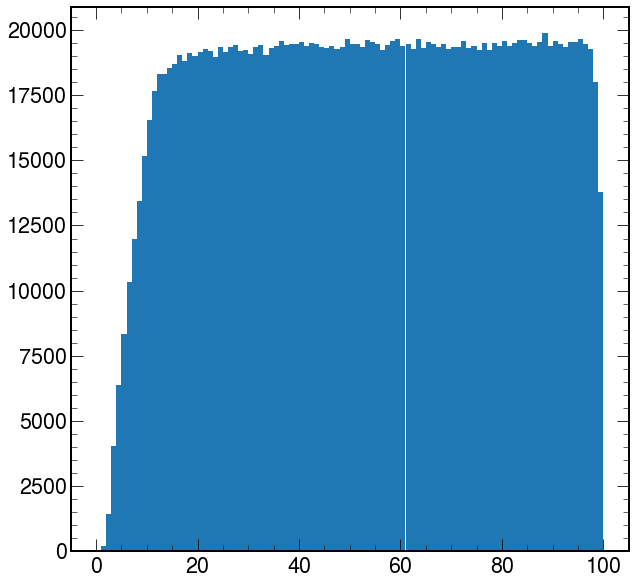

In [9]:
plt.hist(df.et_gen, bins=100, range=(0, 100))

(array([  125.,   630.,  2892.,  6034.,  8834., 10990., 12901., 14438.,
        16584., 18098., 19344., 19722., 19981., 19999., 20431., 20412.,
        20354., 20319., 20235., 20570., 20486., 20234., 20299., 20436.,
        20631., 20485., 20510., 20368., 20290., 20275., 20141., 20401.,
        20473., 20329., 20347., 20620., 20496., 20448., 20568., 20285.,
        20398., 20521., 20126., 20296., 20160., 20395., 20094., 20318.,
        20359., 20511., 20271., 20246., 20418., 20321., 20084., 20198.,
        20440., 20258., 19913., 20271., 20153., 20047., 20083., 20040.,
        20143., 19859., 19773., 19805., 19883., 20251., 19715., 19814.,
        19743., 19649., 19773., 19759., 19828., 19691., 19879., 19814.,
        19726., 19354., 19656., 19670., 19444., 19311., 19254., 19007.,
        18800., 18572., 18095., 17554., 16885., 15368., 13642., 11479.,
         9203.,  6581.,  3447.,   986.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12., 

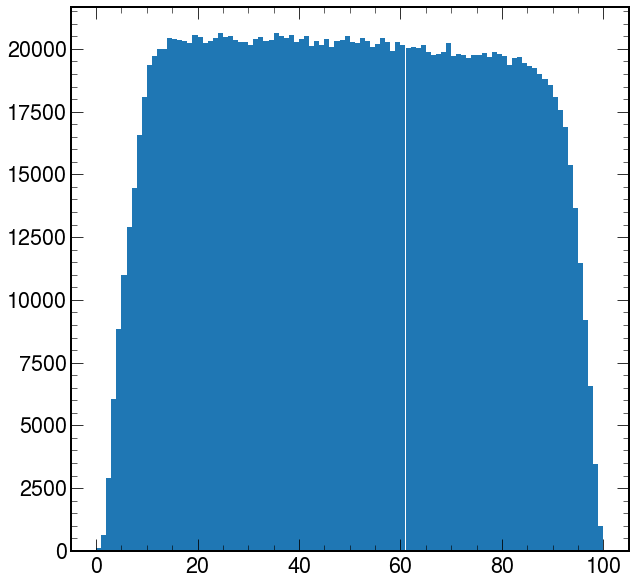

In [10]:
plt.hist(df.et_sim, bins=100, range=(0, 100))

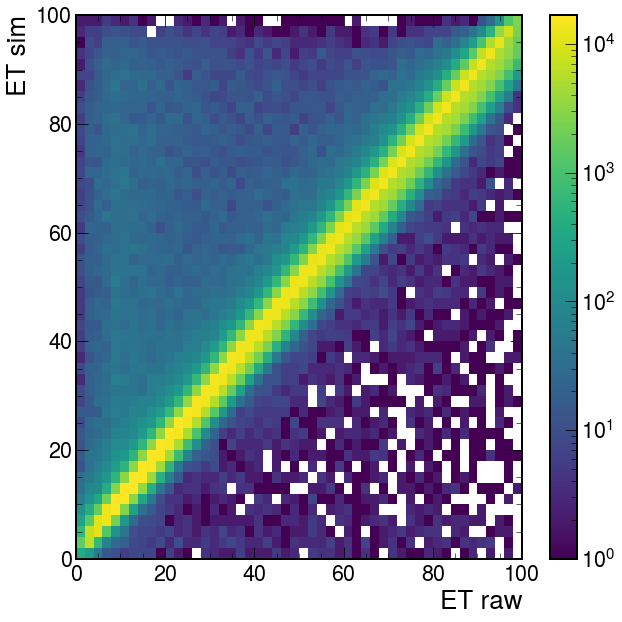

In [11]:
plt.hist2d(df_d1.et_raw, df_d1.et_sim, bins=(50,50), range=((0,100),(0,100)), cmin=1, norm=colors.LogNorm())
plt.xlabel("ET raw")
plt.ylabel("ET sim")
plt.colorbar()

Text(0, 1, 'ET sim')

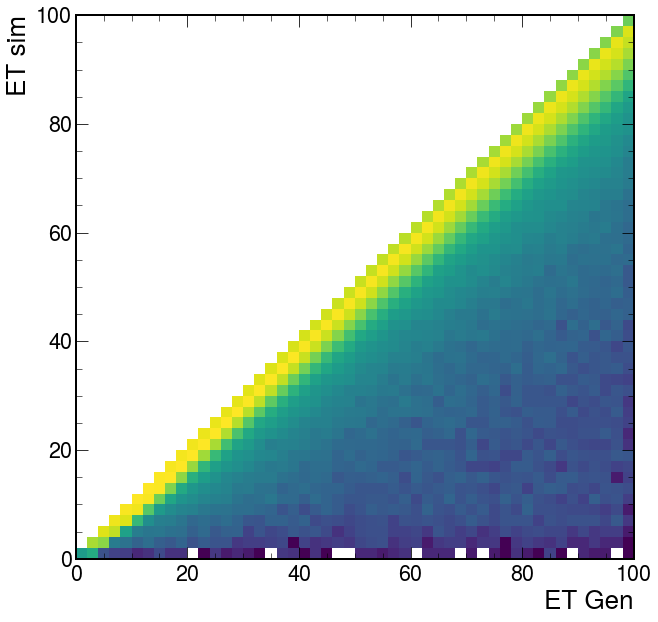

In [12]:
plt.hist2d(df_d1.et_gen, df_d1.et_sim, bins=(50,50), range=((0,100),(0,100)), cmin=1, norm=colors.LogNorm())
plt.xlabel("ET Gen")
plt.ylabel("ET sim")

Text(1, 0, 'ET raw/sim')

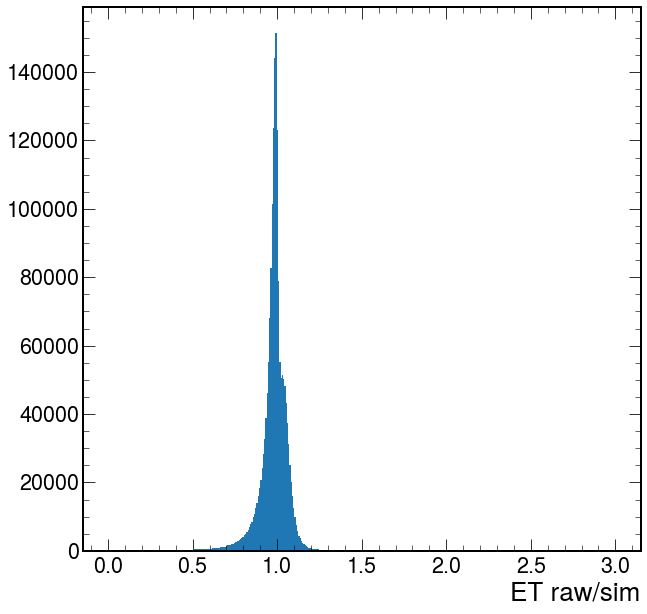

In [54]:
plt.hist(df_d1.et_raw/df_d1.et_sim, bins=400, range=(0,3))
plt.xlabel("ET raw/sim")

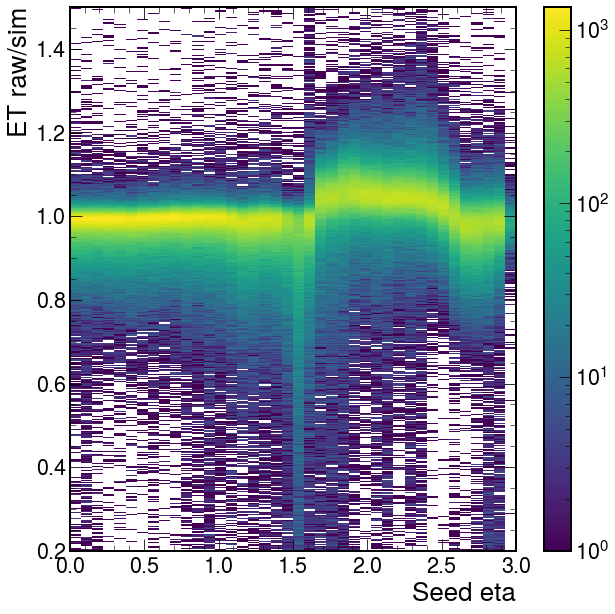

In [55]:
plt.hist2d(df_m1.sc.seedEta, df_m1.et_raw/df_m1.et_sim, bins=(40,500), range=((0,3),(0.2,1.5)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed eta")
plt.colorbar()

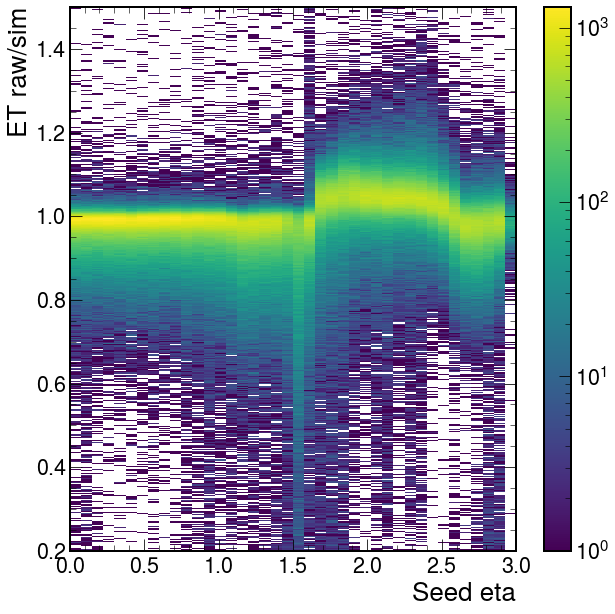

In [14]:
plt.hist2d(df_d1.sc.seedEta, df_d1.et_raw/df_d1.et_sim, bins=(40,500), range=((0,3),(0.2,1.5)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed eta")
plt.colorbar()

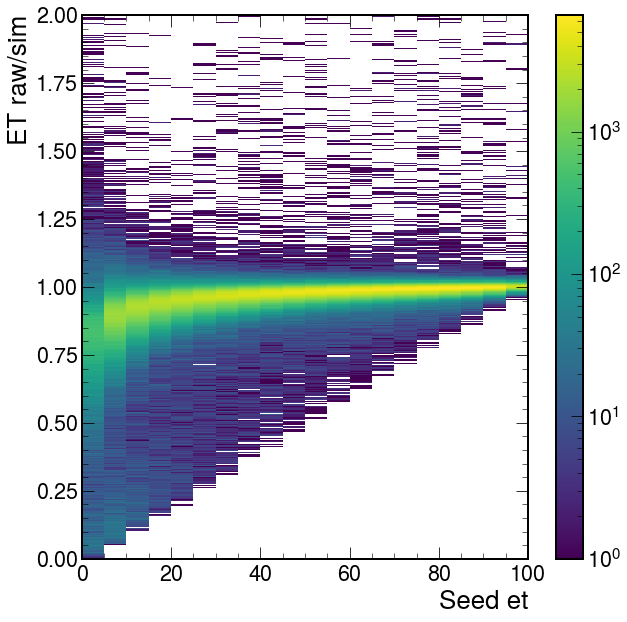

In [31]:
mask = df_d1.seed_eta.abs() < 1.45
plt.hist2d(df_d1[mask].et_seed, df_d1[mask].et_raw/df_d1[mask].et_sim, bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed et")
plt.colorbar()

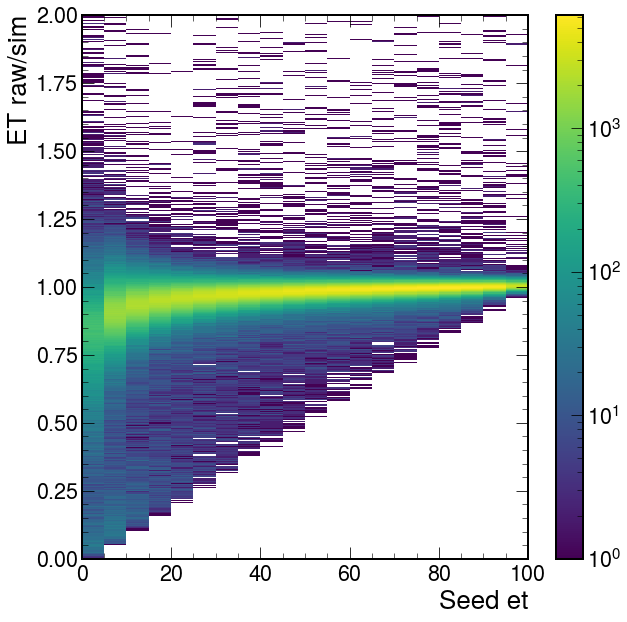

In [32]:
mask = df_m1.seed_eta.abs() < 1.45
plt.hist2d(df_m1[mask].et_seed, df_m1[mask].et_raw/df_m1[mask].et_sim,  bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed et")
plt.colorbar()

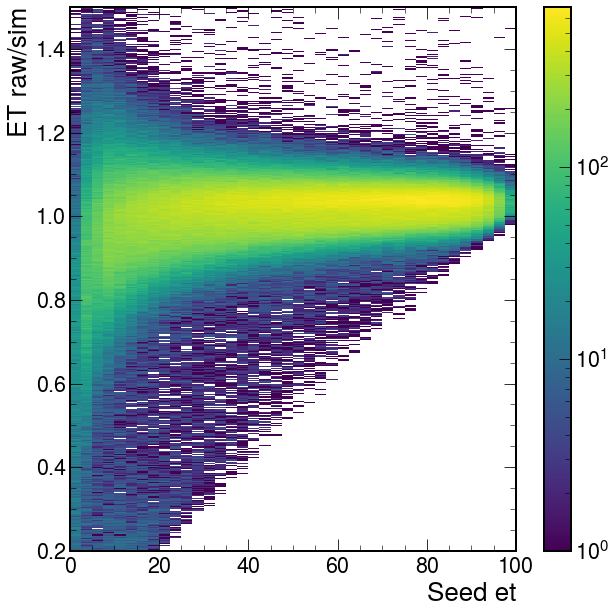

In [24]:
mask = df_d1.seed_eta.abs() > 1.5
plt.hist2d(df_d1[mask].et_seed, df_d1[mask].et_raw/df_d1[mask].et_sim, bins=(40,500), range=((0,100),(0.2,1.5)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed et")
plt.colorbar()

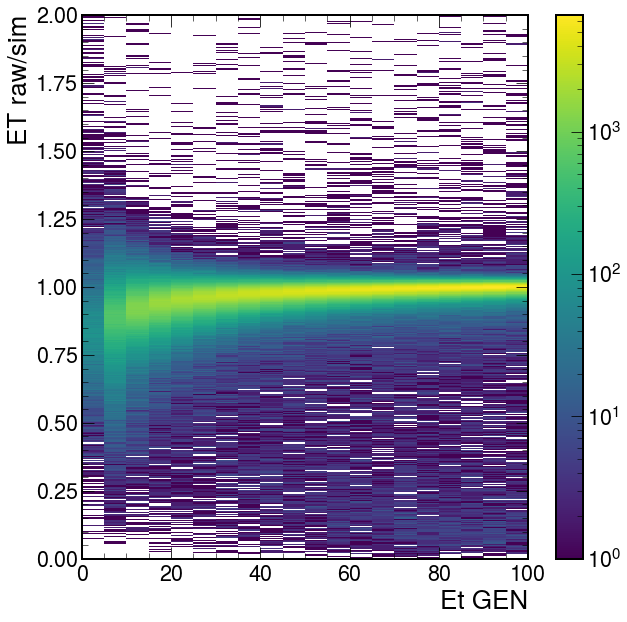

In [56]:
mask = df_m1.seed_eta.abs() < 1.45
plt.hist2d(df_m1[mask].et_gen, df_m1[mask].et_raw/df_m1[mask].et_sim,  bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Et GEN")
plt.colorbar()

# Analyse quantiles explicitly

Text(0.0, 1.01, 'Electrons - DeepSC')

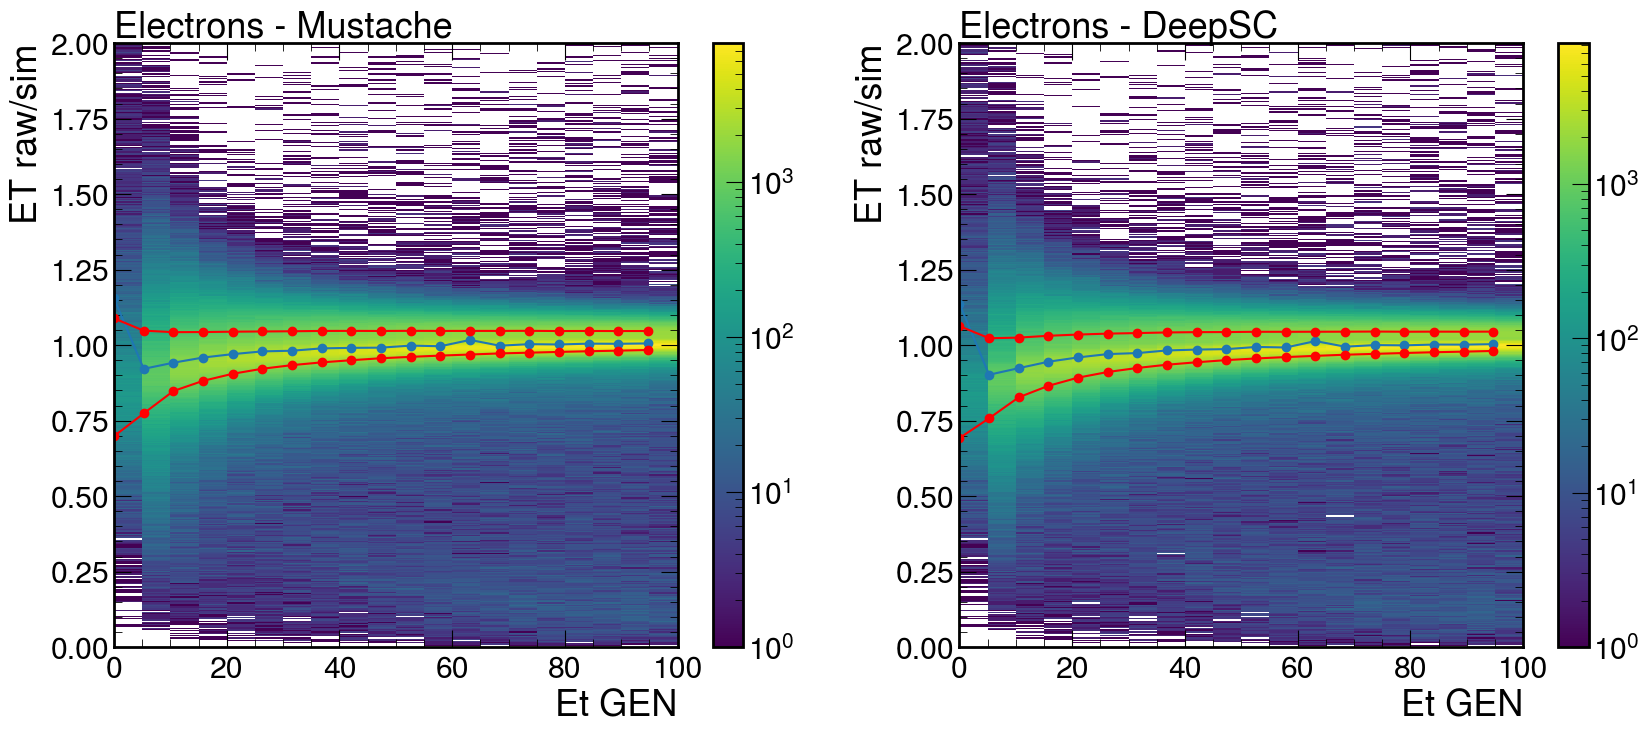

In [83]:
bins = np.linspace(0, 100, 20)

for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, bins, labels=list(range(len(bins)-1)))
    

res_d = df_d1.groupby(["et_bin"]).apply(bin_analysis_details("Eraw_ovEtrue_sim"))
res_m = df_m1.groupby(["et_bin"]).apply(bin_analysis_details("Eraw_ovEtrue_sim"))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_m1.et_gen, df_m1.Eraw_ovEtrue_sim,  bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Et GEN")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.et_bin], res_m.m, marker="o")
ax.plot(bins[res_m.et_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.et_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_d1.et_gen, df_d1.Eraw_ovEtrue_sim,  bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Et GEN")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.et_bin], res_d.m, marker="o")
ay.plot(bins[res_d.et_bin], res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.et_bin], res_d.w68_d, marker="o", color="r")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)



Text(0.0, 1.01, 'Electrons - DeepSC')

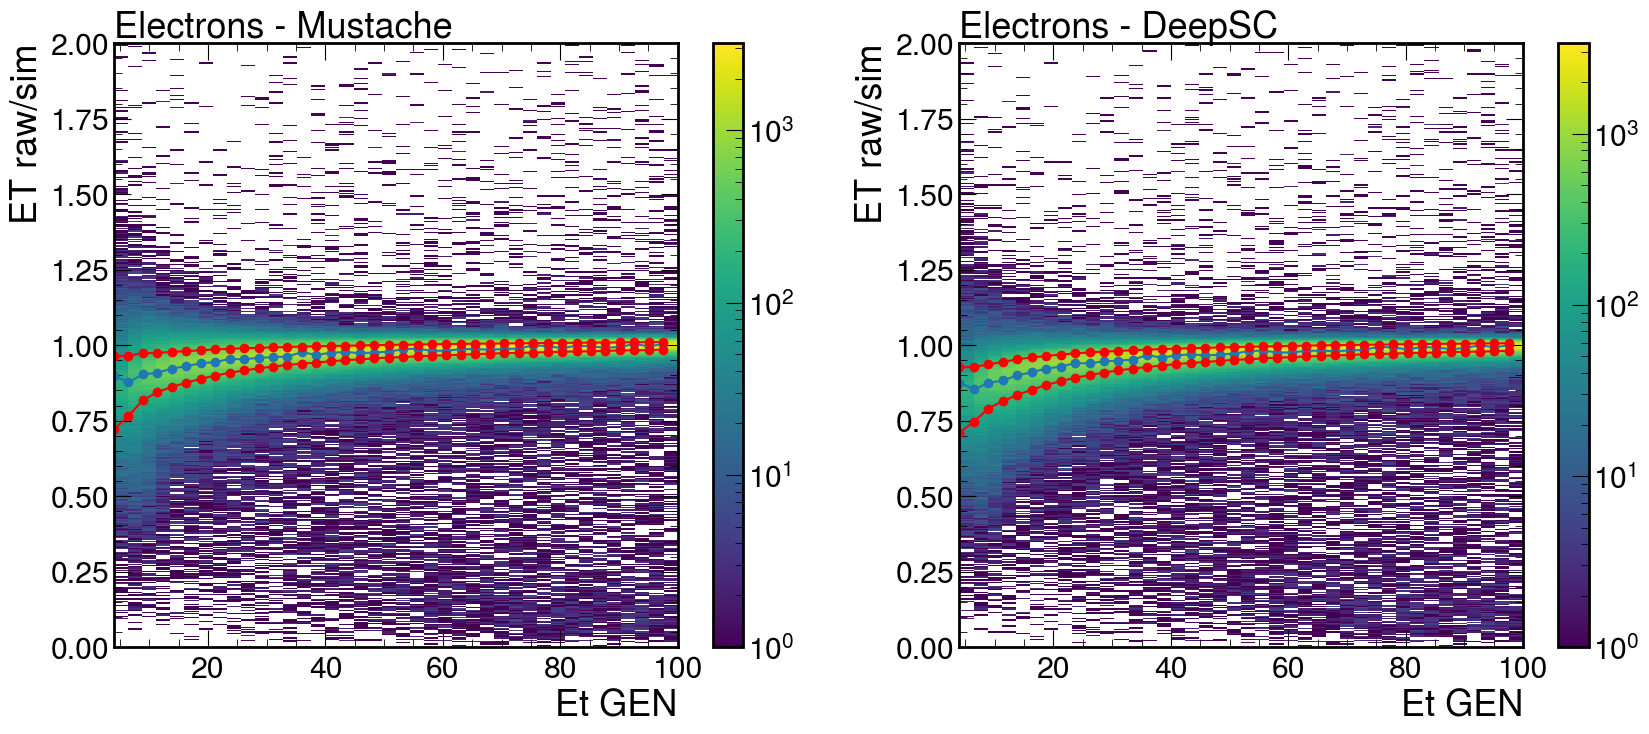

In [104]:
bins = np.linspace(4, 100, 40)

for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, bins, labels=list(range(len(bins)-1)))
    
mask_d_eta = df_d1.seed_eta.abs()<1.45
mask_m_eta = df_m1.seed_eta.abs()<1.45
res_d = df_d1[mask_d_eta].groupby(["et_bin"]).apply(bin_analysis_details("Eraw_ovEtrue_sim"))
res_m = df_m1[mask_m_eta].groupby(["et_bin"]).apply(bin_analysis_details("Eraw_ovEtrue_sim"))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_m1[mask_m_eta].et_gen, df_m1[mask_m_eta].Eraw_ovEtrue_sim,  bins=(40,500), range=((4,100),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Et GEN")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.et_bin], res_m.m, marker="o")
ax.plot(bins[res_m.et_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.et_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_d1[mask_d_eta].et_gen, df_d1[mask_d_eta].Eraw_ovEtrue_sim,  bins=(40,500), range=((4,100),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Et GEN")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.et_bin], res_d.m, marker="o")
ay.plot(bins[res_d.et_bin], res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.et_bin], res_d.w68_d, marker="o", color="r")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)



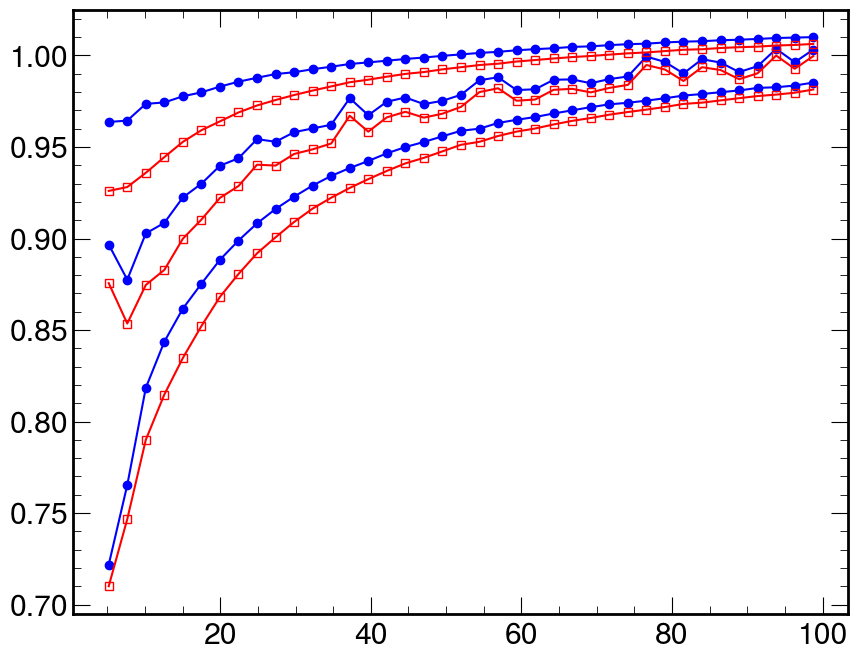

In [106]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +1.2
ax.plot(bins[res_m.et_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.plot(bins[res_d.et_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", )
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r",)
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r")

Text(0.0, 1.01, 'Electrons - DeepSC')

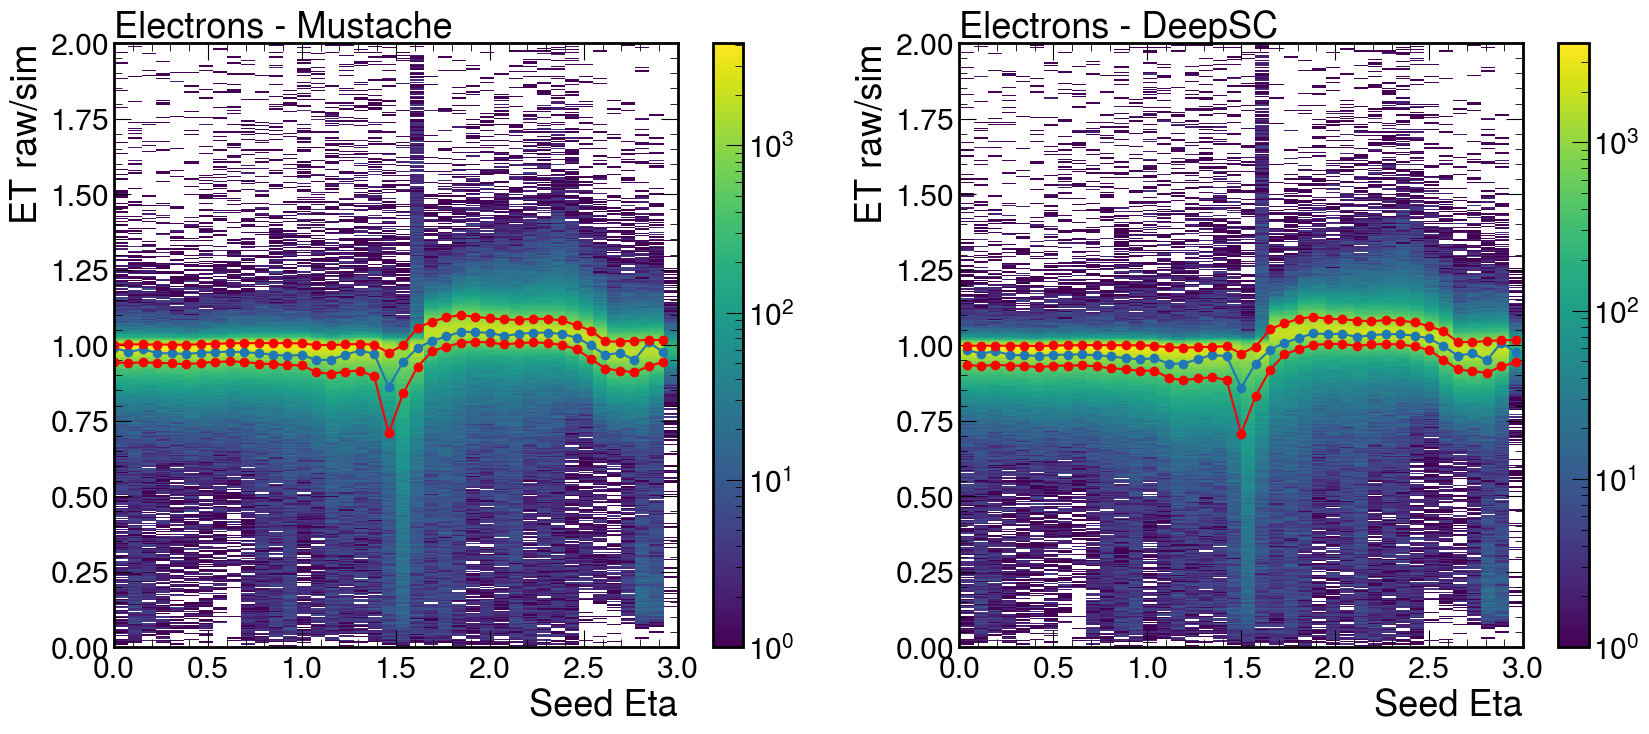

In [94]:
bins = np.linspace(0, 3, 40)

for df in [df_m1, df_d1]:
    df["eta_bin"] = pd.cut(df.seed_eta.abs(), bins, labels=list(range(len(bins)-1)))
    
res_d = df_d1.groupby(["eta_bin"]).apply(bin_analysis_details("Eraw_ovEtrue_sim"))
res_m = df_m1.groupby(["eta_bin"]).apply(bin_analysis_details("Eraw_ovEtrue_sim"))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_m1.seed_eta.abs(), df_m1.Eraw_ovEtrue_sim,  bins=(40,500), range=((0,3),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Seed Eta")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.eta_bin], res_m.m, marker="o")
ax.plot(bins[res_m.eta_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.eta_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_d1.seed_eta.abs(), df_d1.Eraw_ovEtrue_sim,  bins=(40,500), range=((0,3),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Seed Eta")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.eta_bin]+0.0375, res_d.m, marker="o")
ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w68_d, marker="o", color="r")
# ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w95_u, marker="o", color="orange")
# ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w95_d, marker="o", color="orange")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)

<ErrorbarContainer object of 3 artists>

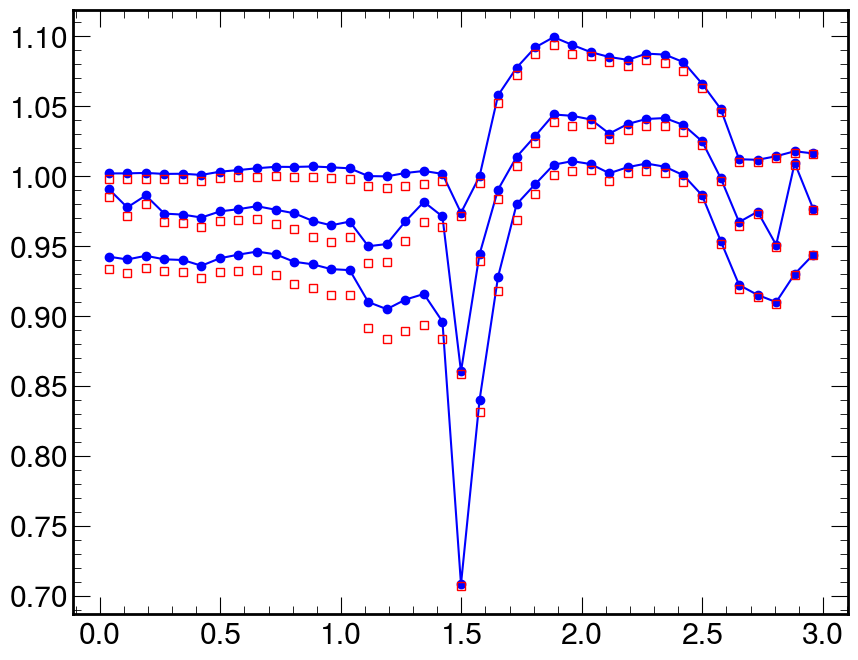

In [99]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +0.037
ax.plot(bins[res_m.eta_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.eta_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.eta_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.errorbar(bins[res_d.eta_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)
ax.errorbar(bins[res_d.eta_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)
ax.errorbar(bins[res_d.eta_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)

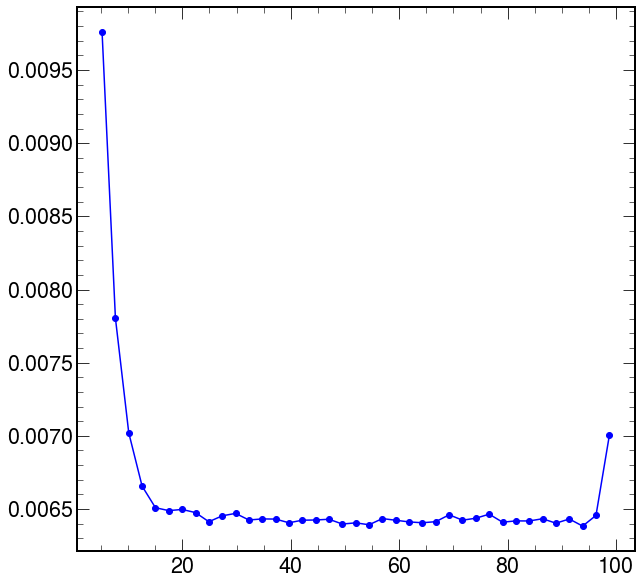

In [111]:
plt.plot(bins[res_m.et_bin]+offset, 1/np.sqrt(res_m.N), marker="o", color="b")


# Central quantiles test

Text(0.0, 1.01, 'Electrons - DeepSC')

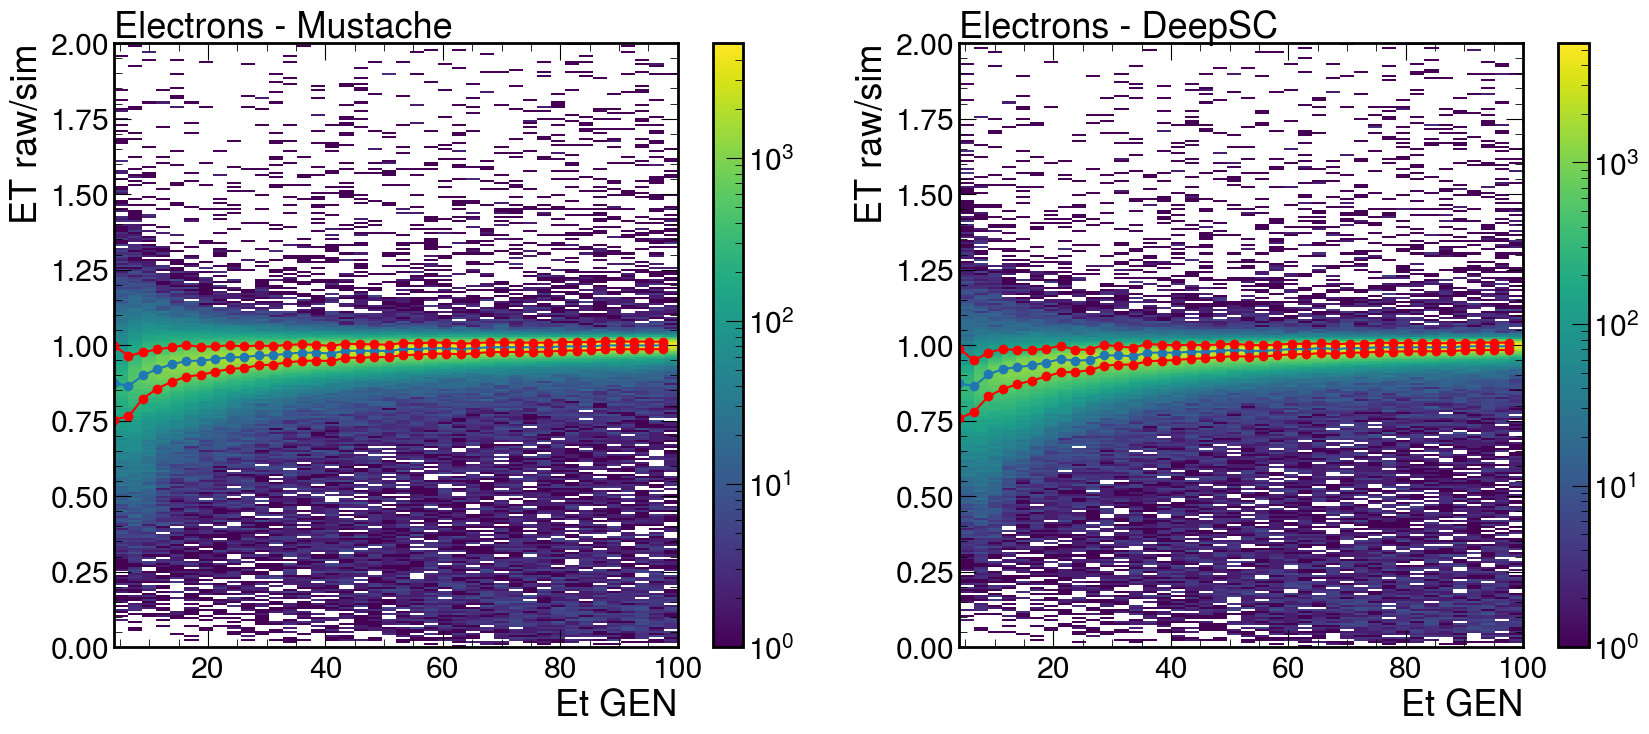

In [299]:
bins = np.linspace(4, 100, 40)

for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, bins, labels=list(range(len(bins)-1)))
    
mask_d_eta = df_d1.seed_eta.abs()<1.45
mask_m_eta = df_m1.seed_eta.abs()<1.45
res_d = df_d1[mask_d_eta].groupby(["et_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim"))
res_m = df_m1[mask_m_eta].groupby(["et_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim"))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_m1[mask_m_eta].et_gen, df_m1[mask_m_eta].Eraw_ovEtrue_sim,  bins=(40,300), range=((4,100),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Et GEN")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.et_bin], res_m.m, marker="o")
ax.plot(bins[res_m.et_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.et_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_d1[mask_d_eta].et_gen, df_d1[mask_d_eta].Eraw_ovEtrue_sim,  bins=(40,300), range=((4,100),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Et GEN")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.et_bin], res_d.m, marker="o")
ay.plot(bins[res_d.et_bin], res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.et_bin], res_d.w68_d, marker="o", color="r")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)


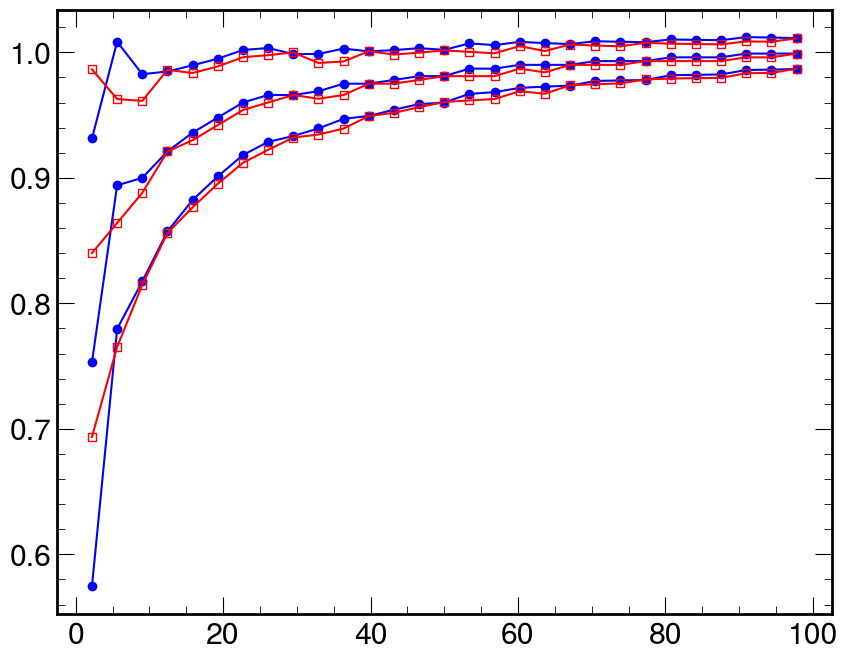

In [298]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +1.2
ax.plot(bins[res_m.et_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.plot(bins[res_d.et_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", )
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r",)
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r")

Text(0.0, 1.01, 'Electrons - DeepSC')

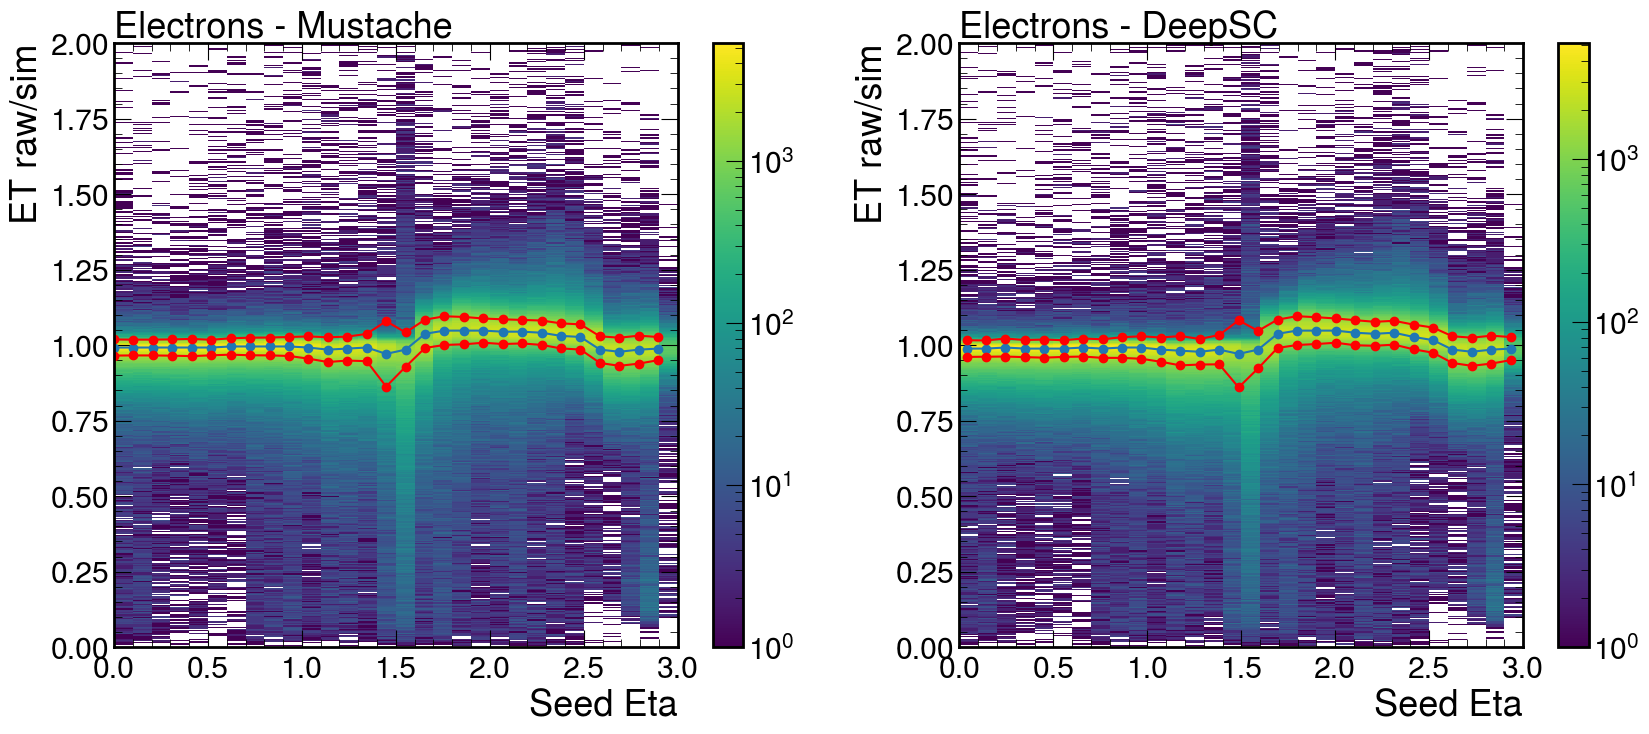

In [328]:
bins = np.linspace(0, 3, 30)

for df in [df_m1, df_d1]:
    df["eta_bin"] = pd.cut(df.seed_eta.abs(), bins, labels=list(range(len(bins)-1)))
    
res_d = df_d1.groupby(["eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim", xrange=(0.6,1.3), nbins=200))
res_m = df_m1.groupby(["eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim",xrange=(0.6,1.3), nbins=200))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_m1.seed_eta.abs(), df_m1.Eraw_ovEtrue_sim,  bins=(30,500), range=((0,3),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Seed Eta")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.eta_bin], res_m.m, marker="o")
ax.plot(bins[res_m.eta_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.eta_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_d1.seed_eta.abs(), df_d1.Eraw_ovEtrue_sim,  bins=(30,500), range=((0,3),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Seed Eta")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.eta_bin]+0.0375, res_d.m, marker="o")
ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w68_d, marker="o", color="r")
# ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w95_u, marker="o", color="orange")
# ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w95_d, marker="o", color="orange")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)

<ErrorbarContainer object of 3 artists>

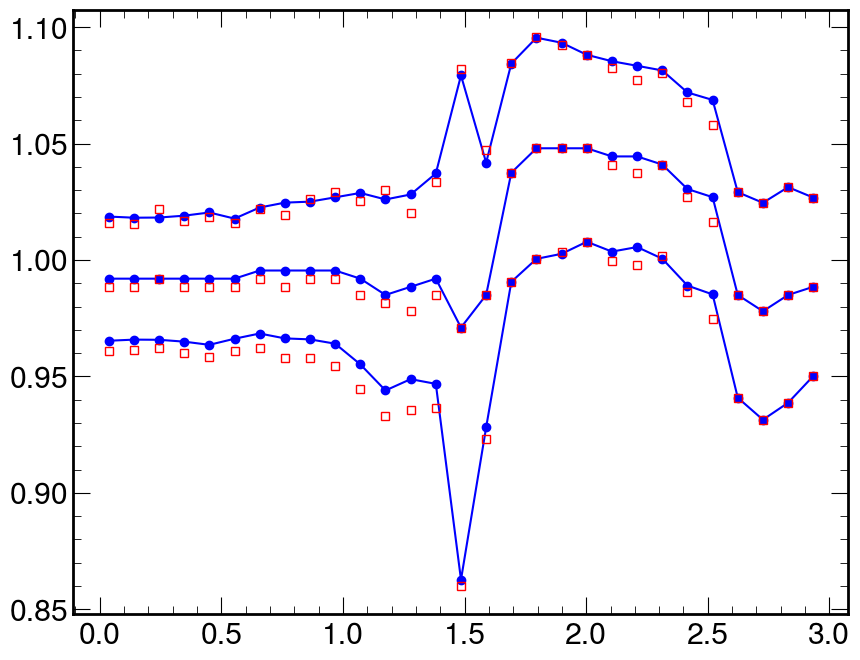

In [330]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +0.037
ax.plot(bins[res_m.eta_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.eta_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.eta_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.errorbar(bins[res_d.eta_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)
ax.errorbar(bins[res_d.eta_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)
ax.errorbar(bins[res_d.eta_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)

Text(0.0, 1.01, 'Electrons - DeepSC')

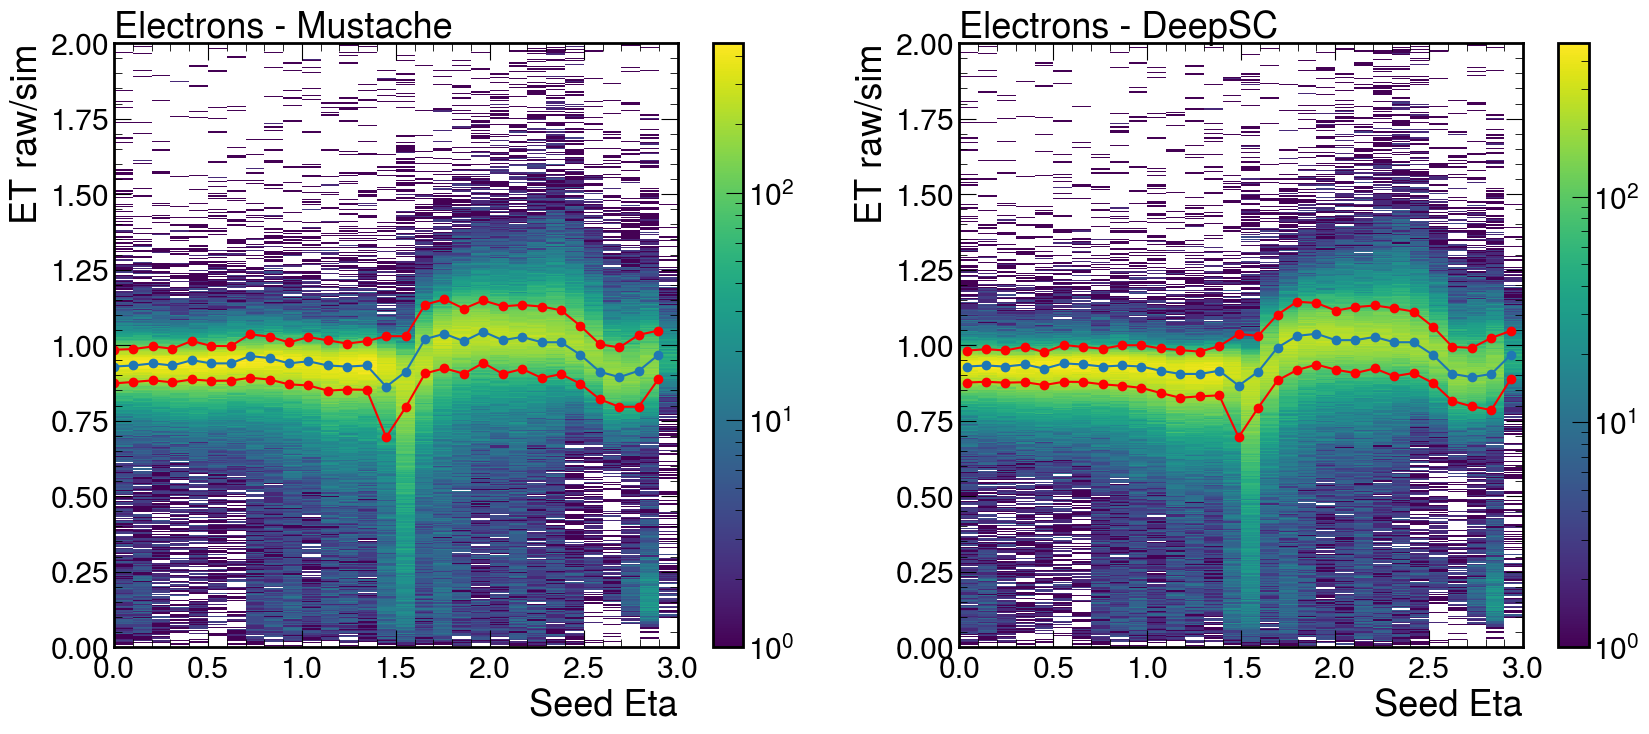

In [335]:
bins = np.linspace(0, 3, 30)

for df in [df_m1, df_d1]:
    df["eta_bin"] = pd.cut(df.seed_eta.abs(), bins, labels=list(range(len(bins)-1)))
    
mask_m = df_m1.et_seed <20
mask_d = df_d1.et_seed < 20
res_d = df_d1[mask_d].groupby(["eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim", xrange=(0.6,1.3), nbins=200))
res_m = df_m1[mask_m].groupby(["eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim",xrange=(0.6,1.3), nbins=200))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_m1[mask_m].seed_eta.abs(), df_m1[mask_m].Eraw_ovEtrue_sim,  bins=(30,500), range=((0,3),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Seed Eta")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.eta_bin], res_m.m, marker="o")
ax.plot(bins[res_m.eta_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.eta_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_d1[mask_d].seed_eta.abs(), df_d1[mask_d].Eraw_ovEtrue_sim,  bins=(30,500), range=((0,3),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Seed Eta")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.eta_bin]+0.0375, res_d.m, marker="o")
ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w68_d, marker="o", color="r")
# ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w95_u, marker="o", color="orange")
# ay.plot(bins[res_d.eta_bin]+0.0375, res_d.w95_d, marker="o", color="orange")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)

<ErrorbarContainer object of 3 artists>

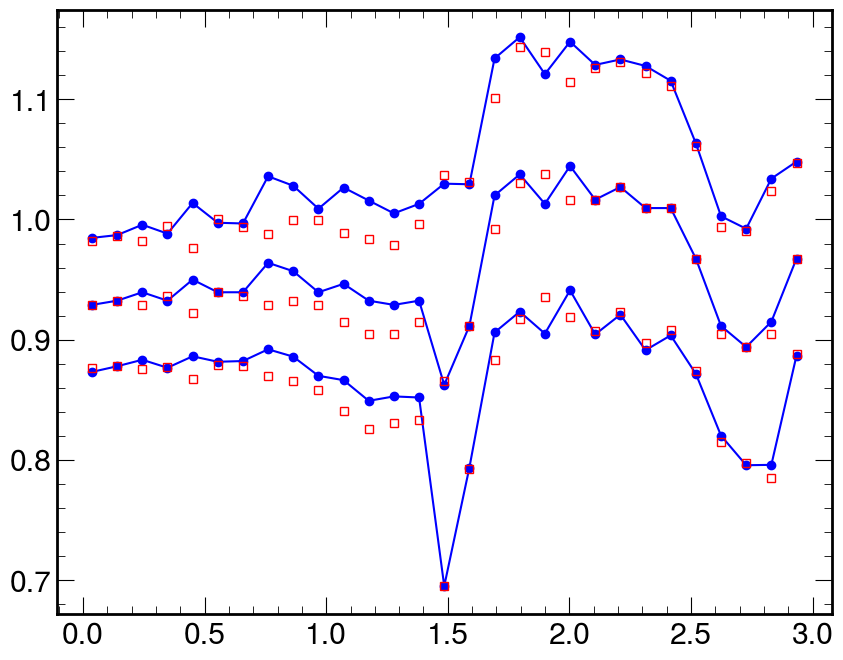

In [336]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +0.037
ax.plot(bins[res_m.eta_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.eta_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.eta_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.errorbar(bins[res_d.eta_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)
ax.errorbar(bins[res_d.eta_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)
ax.errorbar(bins[res_d.eta_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r", linestyle='none', elinewidth=0)

# Resolution plot

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

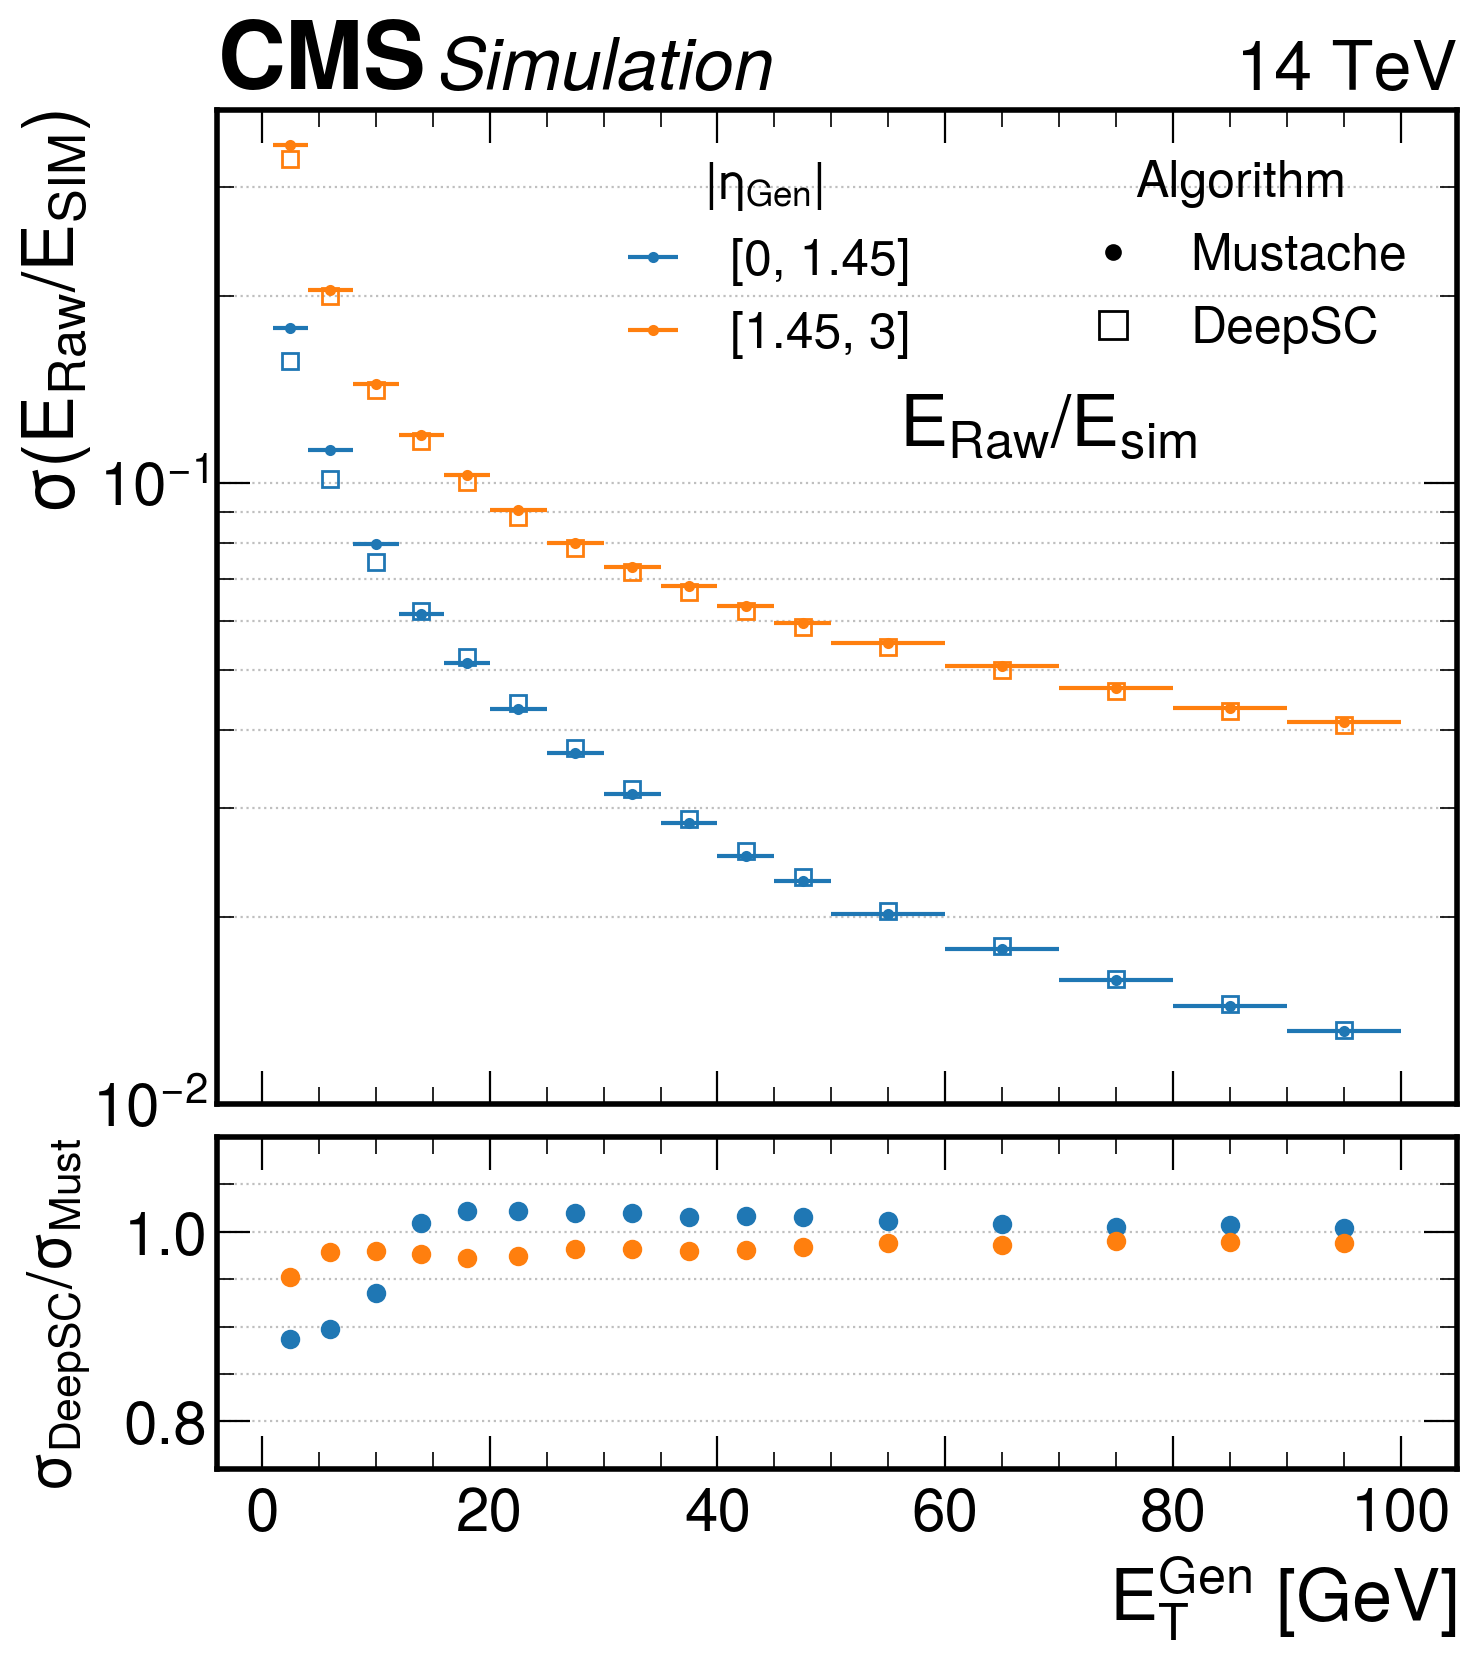

In [302]:
ets = [1, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
etas = [0, 1.45, 3]
for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sc.seedEta), etas, labels=list(range(len(etas)-1)))


res = df_d1.groupby(["et_bin","eta_bin"]).apply(bin_analysis("Eraw_ovEtrue_sim"))
res_must = df_m1.groupby(["et_bin","eta_bin"]).apply(bin_analysis("Eraw_ovEtrue_sim"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

fig = plt.figure(figsize=(8,9), dpi=200)
gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
axs = gs.subplots(sharex=True)

errx = []
x = []
for i in range(len(ets)-1):
    errx.append((ets[i+1]- ets[i])/2)
    x.append((ets[i+1]+ ets[i])/2)

mustl = []
deepl = []



for ieta, eta in enumerate(etas[:-1]):
    l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
    mustl.append(l)

for ieta, eta in enumerate(etas[:-1]):
    l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                            marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
    deepl.append(l)


for ieta, eta in enumerate(etas[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
    var = res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68
    axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

axs[0].set_ylabel("$\sigma (E_{Raw}/E_{SIM})$")

axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
# ax.plot([0,100],[1,1], linestyle="dashed", color="black")
axs[0].set_ylim(1e-2, 0.4)
axs[1].set_ylim(0.75, 1.10)
axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
axs[0].get_yaxis().set_label_coords(-0.1,1)
axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

axs[0].text(0.55, 0.66, flavour, transform=axs[0].transAxes)
axs[0].set_yscale("log")

l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)

ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
axs[0].add_artist(l1)
axs[1].grid(axis="y",which="both")
axs[0].grid(axis="y", which="both")

hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.png".format(flavour))
# fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.pdf".format(flavour))
# fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.svg".format(flavour))

# Resolution by ET with central quantiles

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

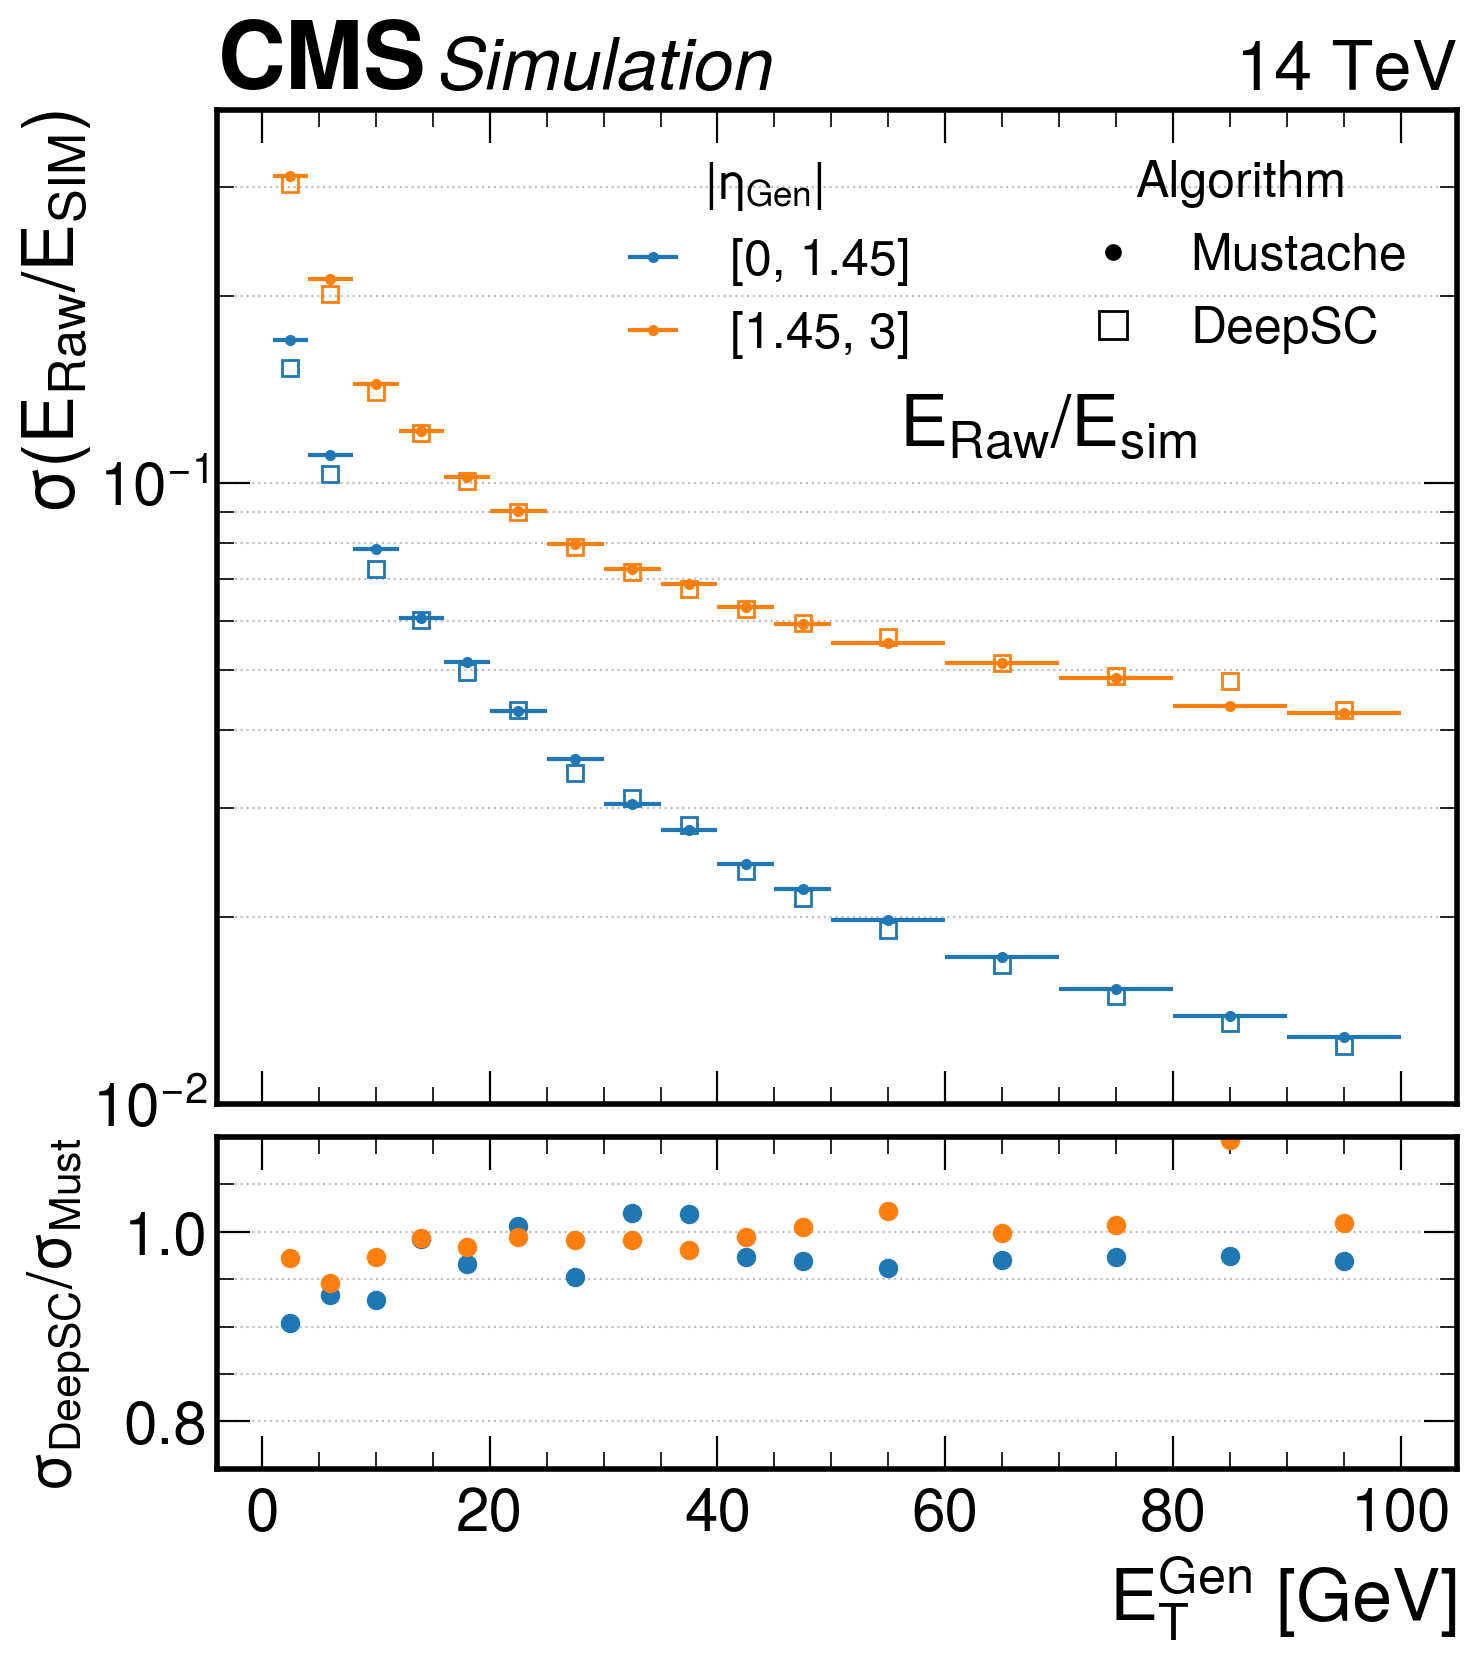

In [303]:
ets = [1, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
etas = [0, 1.45, 3]
for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sc.seedEta), etas, labels=list(range(len(etas)-1)))


res = df_d1.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim",xrange=(0.5, 1.3), nbins=400))
res_must = df_m1.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim",xrange=(0.5, 1.3), nbins=400))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

fig = plt.figure(figsize=(8,9), dpi=200)
gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
axs = gs.subplots(sharex=True)

errx = []
x = []
for i in range(len(ets)-1):
    errx.append((ets[i+1]- ets[i])/2)
    x.append((ets[i+1]+ ets[i])/2)

mustl = []
deepl = []



for ieta, eta in enumerate(etas[:-1]):
    l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
    mustl.append(l)

for ieta, eta in enumerate(etas[:-1]):
    l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                            marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
    deepl.append(l)


for ieta, eta in enumerate(etas[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
    var = res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68
    axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

axs[0].set_ylabel("$\sigma (E_{Raw}/E_{SIM})$")

axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
# ax.plot([0,100],[1,1], linestyle="dashed", color="black")
axs[0].set_ylim(1e-2, 0.4)
axs[1].set_ylim(0.75, 1.10)
axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
axs[0].get_yaxis().set_label_coords(-0.1,1)
axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

axs[0].text(0.55, 0.66, flavour, transform=axs[0].transAxes)
axs[0].set_yscale("log")

l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)

ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
axs[0].add_artist(l1)
axs[1].grid(axis="y",which="both")
axs[0].grid(axis="y", which="both")

hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.png".format(flavour))
# fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.pdf".format(flavour))
# fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.svg".format(flavour))

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

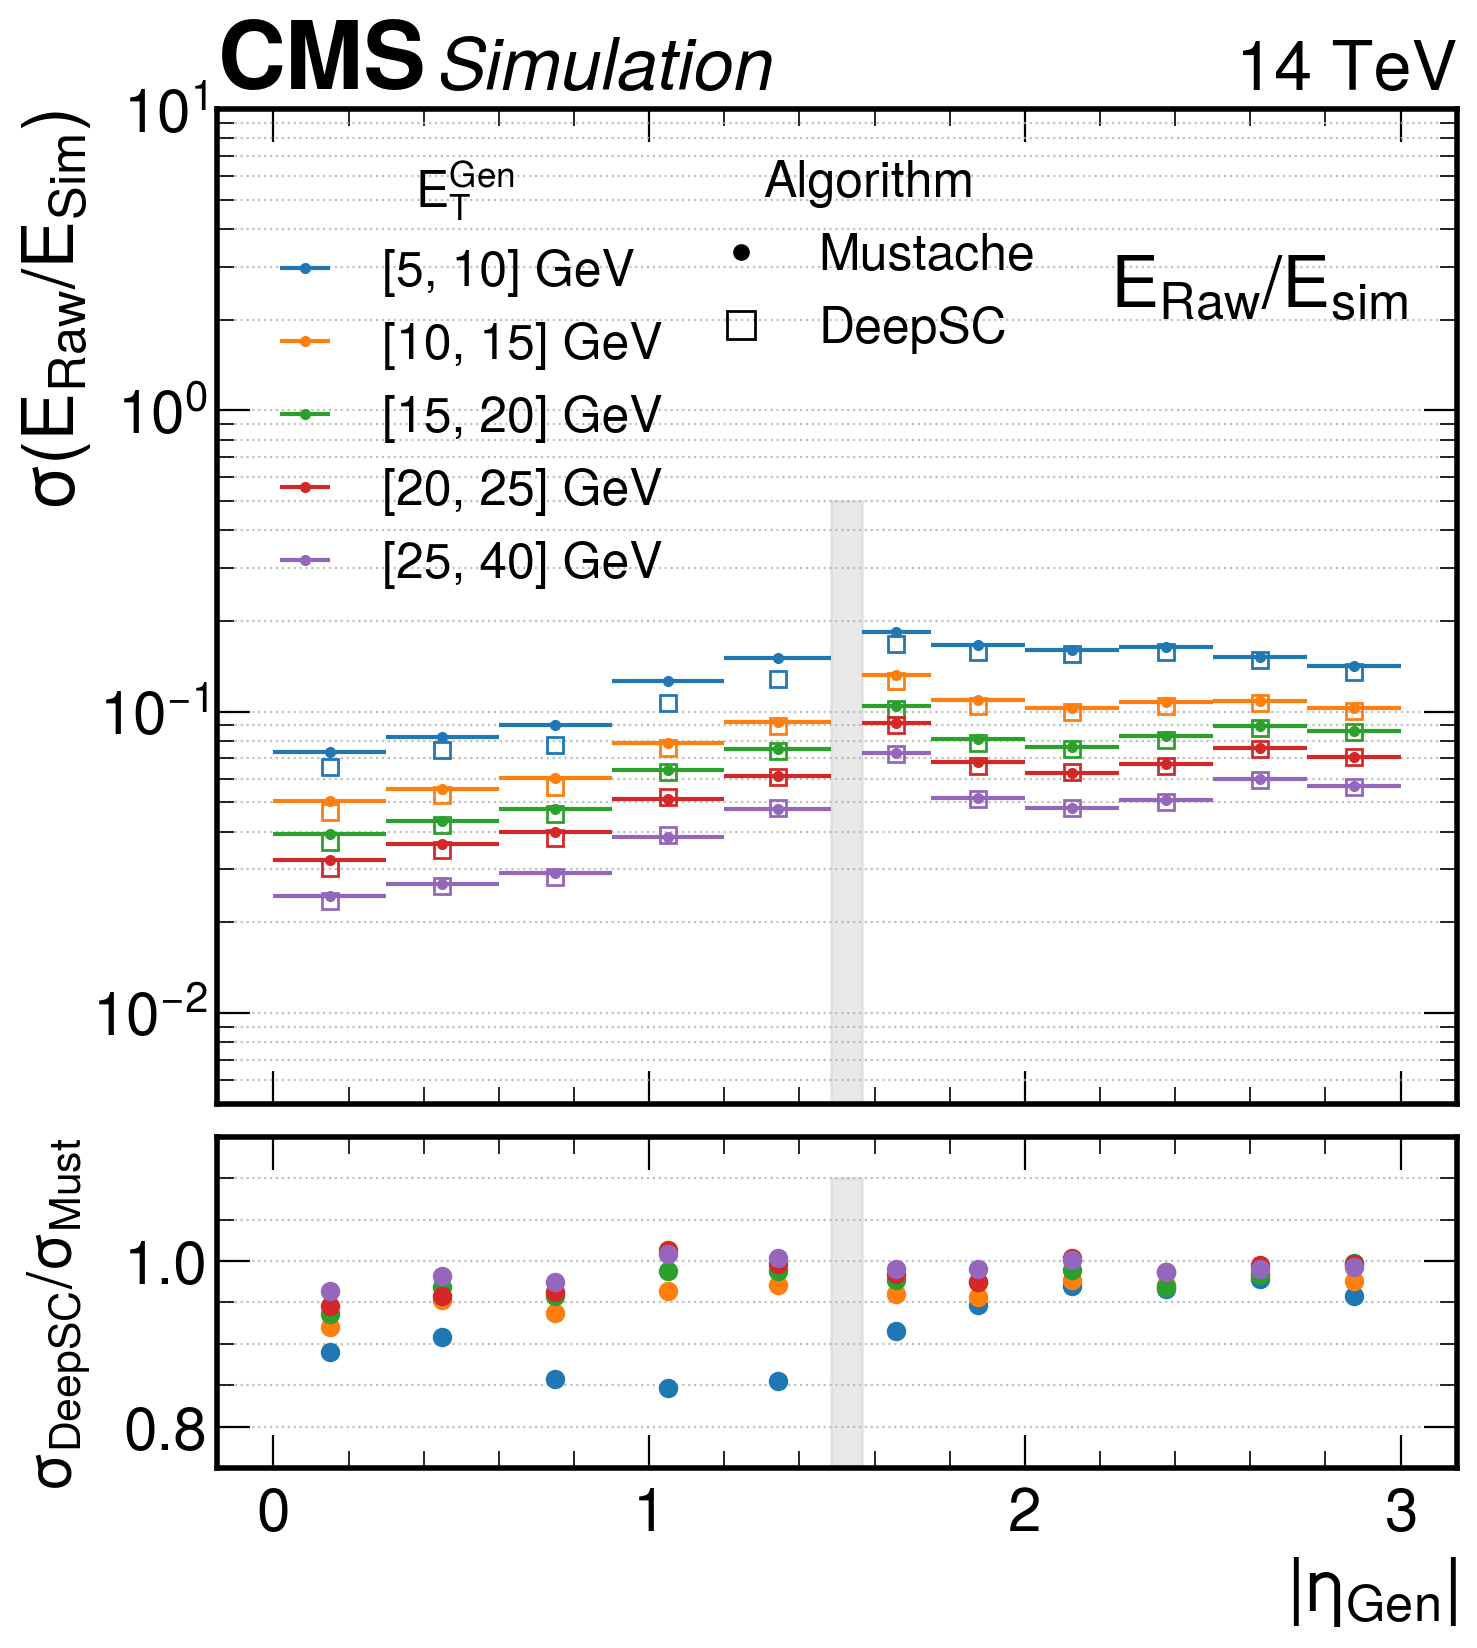

In [305]:
ets = [5,10, 15, 20, 25, 40,60]
iplot = [0, 1, 2, 3,4 ]
etas = [0, 0.3,0.6,0.9,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,2.75,3]
exclude_bin = 5
flavour = flavour

for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim.eta), etas, labels=list(range(len(etas)-1)))


res = df_d1.groupby(["et_bin","eta_bin"]).apply(bin_analysis("Eraw_ovEtrue_sim"))
res_must = df_m1.groupby(["et_bin","eta_bin"]).apply(bin_analysis("Eraw_ovEtrue_sim"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

fig = plt.figure(figsize=(8,9), dpi=200)
gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
axs = gs.subplots(sharex=True)

errx = []
x = []
for i in range(len(etas)-1):
    errx.append((etas[i+1]- etas[i])/2)
    x.append((etas[i+1]+ etas[i])/2)

mustl = []
deepl = []

res.loc[res.eta_bin == exclude_bin, ["w68"]] = 0
res_must.loc[res_must.eta_bin == exclude_bin, ["w68"]] = 0

for iet, et in enumerate(ets[:-1]):
    if iet not in iplot: continue
    l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
    mustl.append(l)

i = 0
for iet, et in enumerate(ets[:-1]):
    if iet not in iplot: continue
    l = axs[0].errorbar(x, res[res.et_bin == iet].w68,  xerr=errx ,label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), 
                            c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
    i+=1
    deepl.append(l)

axs[0].fill_between([1.485, 1.566], [5e-3,5e-3],[0.5,0.5], color="lightgray", alpha=0.5)

for iet, et in enumerate(ets[:-1]):
    if iet not in iplot: continue
    #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
    #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
    var = res[res.et_bin==iet].w68 / res_must[res_must.et_bin==iet].w68
    axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt="o", linestyle='none', elinewidth=0)

axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

l1= axs[0].legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)

ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
axs[0].add_artist(l1)

axs[1].set_xlabel("$|\eta_{Gen}|$")
axs[0].set_ylim(5e-3,1e1)
# ax.plot([0,100],[1,1], linestyle="dashed", color="black")

axs[1].set_ylim(0.75, 1.15)
axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
axs[0].get_yaxis().set_label_coords(-0.1,1)
axs[1].get_yaxis().set_label_coords(-0.1,1)

axs[1].fill_between([1.485, 1.566], [-0.1,-0.1],[1.1,1.1], color="lightgray", alpha=0.5)

#     axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

axs[0].text(0.72, 0.8, flavour, transform=axs[0].transAxes)

axs[0].set_yscale("log")
axs[0].grid(which="both",axis="y")
axs[1].grid(which="both",axis="y")

hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# fig.savefig(output_folder + "/resolution_byeta_{}_ratio.png".format(flavour))
# fig.savefig(output_folder + "/resolution_byeta_{}_ratio.pdf".format(flavour))
# fig.savefig(output_folder + "/resolution_byeta_{}_ratio.svg".format(flavour))


### With central quantiles


(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

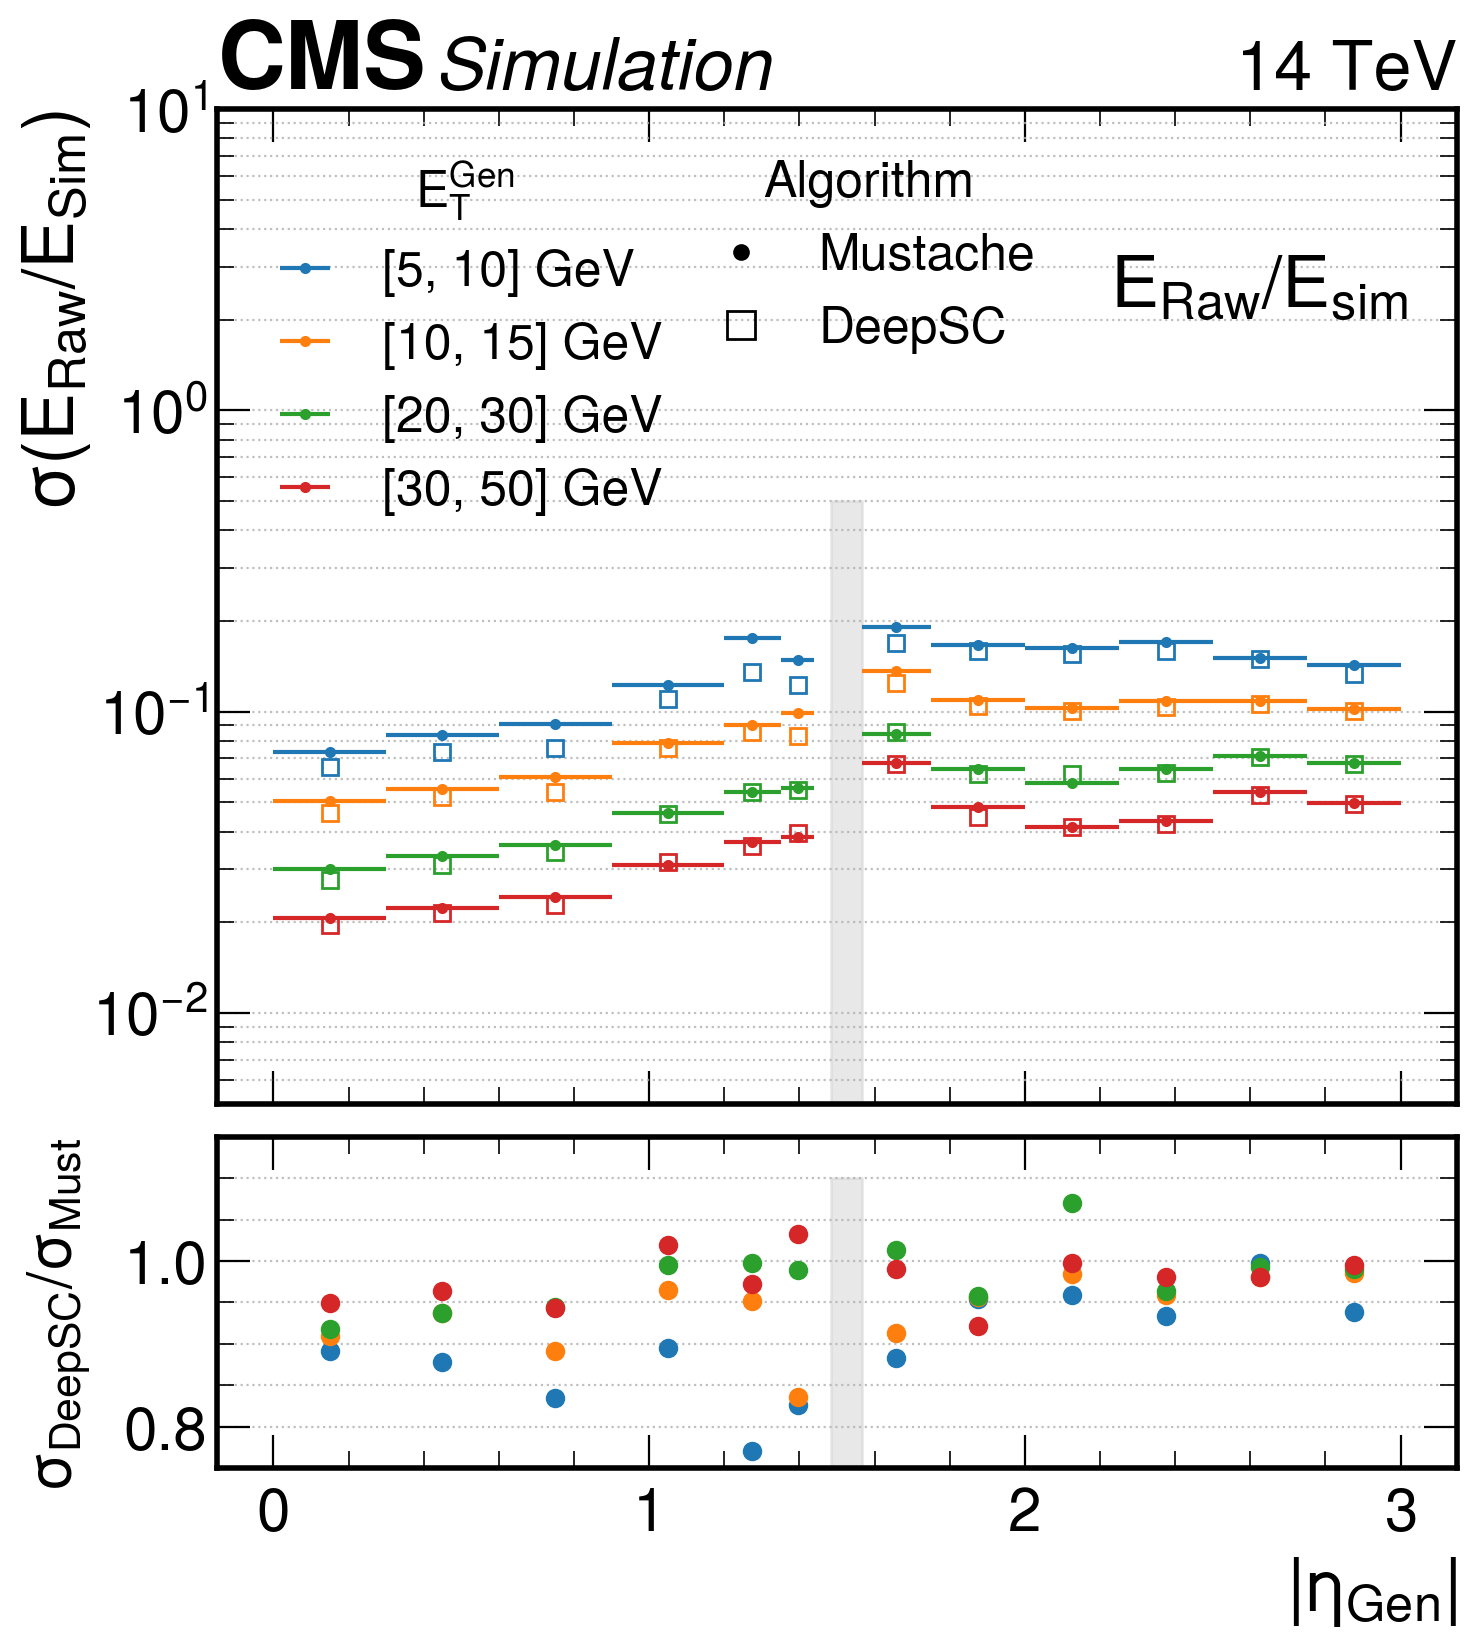

In [337]:
ets = [5,10, 15, 20, 30, 50, 100]
iplot = [0, 1, 3,4 ]
etas = [0, 0.3, 0.6, 0.9,1.2, 1.35, 1.44, 1.566, 1.75, 2.,2.25,2.5,2.75,3]
exclude_bin = 6
flavour = flavour

for df in [df_m1, df_d1]:
    df["et_bin"] = pd.cut(df.et_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim.eta), etas, labels=list(range(len(etas)-1)))


res = df_d1.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim", xrange=(0.6,1.3), nbins=200))
res_must = df_m1.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("Eraw_ovEtrue_sim",xrange=(0.6,1.3), nbins=200))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

fig = plt.figure(figsize=(8,9), dpi=200)
gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
axs = gs.subplots(sharex=True)

errx = []
x = []
for i in range(len(etas)-1):
    errx.append((etas[i+1]- etas[i])/2)
    x.append((etas[i+1]+ etas[i])/2)

mustl = []
deepl = []

res.loc[res.eta_bin == exclude_bin, ["w68"]] = 0
res_must.loc[res_must.eta_bin == exclude_bin, ["w68"]] = 0

for iet, et in enumerate(ets[:-1]):
    if iet not in iplot: continue
    l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
    mustl.append(l)

i = 0
for iet, et in enumerate(ets[:-1]):
    if iet not in iplot: continue
    l = axs[0].errorbar(x, res[res.et_bin == iet].w68,  xerr=errx ,label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), 
                            c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
    i+=1
    deepl.append(l)

axs[0].fill_between([1.485, 1.566], [5e-3,5e-3],[0.5,0.5], color="lightgray", alpha=0.5)

for iet, et in enumerate(ets[:-1]):
    if iet not in iplot: continue
    #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
    #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
    var = res[res.et_bin==iet].w68 / res_must[res_must.et_bin==iet].w68
    axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt="o", linestyle='none', elinewidth=0)

axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

l1= axs[0].legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)

ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
axs[0].add_artist(l1)

axs[1].set_xlabel("$|\eta_{Gen}|$")
axs[0].set_ylim(5e-3,1e1)
# ax.plot([0,100],[1,1], linestyle="dashed", color="black")

axs[1].set_ylim(0.75, 1.15)
axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
axs[0].get_yaxis().set_label_coords(-0.1,1)
axs[1].get_yaxis().set_label_coords(-0.1,1)

axs[1].fill_between([1.485, 1.566], [-0.1,-0.1],[1.1,1.1], color="lightgray", alpha=0.5)

#     axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

axs[0].text(0.72, 0.8, flavour, transform=axs[0].transAxes)

axs[0].set_yscale("log")
axs[0].grid(which="both",axis="y")
axs[1].grid(which="both",axis="y")

hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# fig.savefig(output_folder + "/resolution_byeta_{}_ratio.png".format(flavour))
# fig.savefig(output_folder + "/resolution_byeta_{}_ratio.pdf".format(flavour))
# fig.savefig(output_folder + "/resolution_byeta_{}_ratio.svg".format(flavour))
